In [1]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from datetime import date, datetime
import matplotlib.pyplot as plt
import mysql.connector as sq
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, f1_score

import seaborn as sns
import json
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import os

# Cargamos las variables de entorno
load_dotenv()

# Lista de columnas
lst_col = [
    "dr0",
    "dr7",
    "dr15",
    "dr30",
    "dr60",
    "dr90",
    "dr180",
    "dr",
    #"yield"
]


# ANALISIS EXPLORATORIO DEL MODELO DE FRAUDE
## Funciones

Las variables escogidas para realziar las primeras pruebas son las siguientes

- bank_name 
- Amount
- Days
- Promo_code_id
- ip_asn_flag 
- ip_city_flag
- data_breaches
- is_apple_relay
- digital_presence_score
- num_profesional_network_tools
- good_behavioral_apps
- is_nie

### Funciones de Cálculos

In [2]:
#########################################################################################################################################################
################################################################ FUNCIONES ##############################################################################
#########################################################################################################################################################
def get_connection():
    """
    Establece y devuelve una conexión a la base de datos MySQL utilizando las variables de entorno definidas.

    Returns
    -------
    mysql.connector.connection.MySQLConnection
        Objeto de conexión activo a la base de datos MySQL.
    """
    return sq.connect(
        host=os.getenv("DB_HOST"),
        user=os.getenv("DB_USER"),
        password=os.getenv("DB_PASSWORD"),
        database=os.getenv("DB_NAME"),
        use_pure=True,   
    )

def get_querys(lst_query):
    """
    Función encargada de realizar las querys y devolver los datos de estas consultas en formato de DataFrame.
    
    Parameters
    ----------
    lst_query (list): Lista con todas las querys que vamos a realizar.

    Returns
    -------
    pandas.DataFrame: DataFrame con los resultados de las consultas.
    """
    print("Comenzamos a hacer las consultas")
    # Lista con todos los df
    lst_df = []
    # Establecemos la conexion
    conn = get_connection()
    # Creamos el cursor para ejecutar las queries
    cur = conn.cursor()

    for query in lst_query:
        cur.execute(query)
        # Guardamos el resultado
        table_result = cur.fetchall()
        column_names = [desc[0] for desc in cur.description] # Guardamos los nombres de las columnas
        # Creamos un df a partir del resultado
        lst_df.append(pd.DataFrame(table_result, columns=column_names))

    cur.close()
    conn.close()

    print("✅ Consultas finalizadas")
    return lst_df

    
def shrinkage(df, var, dr='dr90'):

    # Calculamos la cantidad de datos de cada uno de las categorias de var
    df_count = df[var].value_counts().reset_index()

    # Media global de DR
    global_dr = df[dr].mean()

    # Calculamos la media de cada uno de los subgrupos
    df_mean = df.groupby(var)[dr].mean().reset_index()

    # Combinamos los dos df donde tenemos la media de cada uno de los bancos
    df_mean = df_mean.merge(df_count, on=var, how='left') 

    df_mean[var+"_shrinkage"] = ( (df_mean["count"] * df_mean[dr]) + (1000*global_dr)) / (global_dr + df_mean["count"])

    df = df.merge(df_mean[[var, var+"_shrinkage"]], on=var, how='left')

    return df

def var_mean(df, var, dr='dr90'):

    # Calculamos la cantidad de datos de cada uno de las categorias de var
    df_count = df[var].value_counts().reset_index()

    # Calculamos la media de cada uno de los subgrupos
    df_mean = df.groupby(var)[dr].mean().reset_index().rename(columns={dr: var+"_shrinkage"})

    # Combinamos los dos df donde tenemos la media de cada uno de los bancos
    df_mean = df_mean.merge(df_count, on=var, how='left') 

    df = df.merge(df_mean[[var,  var+"_shrinkage"]], on=var, how='left')

    return df

    
def safe_bool(v):
    # Normaliza None / bool / 0-1 / "true"/"false"
    if v is None:
        return 0

    if isinstance(v, bool):
        return int(v)

    if isinstance(v, (int, float)):
        return int(v != 0)

    if isinstance(v, str):
        return int(v.strip().lower() in ("1", "true", "yes", "y", "t"))

    return int(bool(v))


def calculate_num_platforms(df, lst_cols_trust, var_name):

    df[var_name] = (
        df[lst_cols_trust]
        .fillna(0)
        .astype("int8")
        .sum(axis=1)
    )

    return df


def calculate_tramo_creation(df, var, bins, labels, tramo_var='tramo'):
    df[tramo_var] = pd.cut(
        df[var],
        bins=bins,
        labels=labels,
        include_lowest=True
    )
    return df


def prep_catboost(X, cat_cols):
    X = X.copy()
    for c in cat_cols:
        # Rellena NaN y convierte a string
        X[c] = X[c].astype("object").fillna("__MISSING__").astype(str)
    return X

def match_names( name1, name2):
    if name1 in name2:
        return 1
    elif name2 in name1:
        return 1
    return 0 

def auc_gini(df, var, dr, threshold=0.8):
    df = df.copy()
    df[dr] = np.where(df[dr]>=threshold,1,0)
    y = df[dr].astype(int).values
    X = df[var].astype(str)

    p_global = y.mean()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    oof_score = np.zeros(len(df), dtype=float)

    for tr_idx, va_idx in skf.split(X, y):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr = y[tr_idx]

        # media por banco SOLO en train
        bank_rate = pd.Series(y_tr, index=X_tr).groupby(level=0).mean()

        # score para valid: si no existe el banco en train -> global
        oof_score[va_idx] = X_va.map(bank_rate).fillna(p_global).values

    auc = roc_auc_score(y, oof_score)
    gini = 2*auc - 1
    return auc, gini

def full_analysis_by_var(df, var, dr, title, dr_evolution=False, calculate_gini=False):
    """
    Ejecuta el análisis completo de una variable:
    - Lift plot con CI
    - Evolución temporal del DR
    - AUC y Gini
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame de entrada
    var : str
        Variable categórica / binning (ej. 'tramo_platforms')
    dr : str
        Variable de default binaria (ej. 'dr90')
    title : str
        Título del gráfico temporal
    
    Returns
    -------
    results : dict
        Diccionario con AUC y Gini
    """
    print("#" * 150)
    print("#" * 150)
    print(f"\n📊 Análisis de variable: {var}")
    print("-" * 50)

    # 1️⃣ Lift + CI
    df_lift = plot_lift_by_var(df, dr, var)

    # 2️⃣ Evolución temporal
    line_plot(
        df,
        var,
        lst_col,
        title
    )
    if calculate_gini:
        auc, gini = auc_gini(df, var, dr)

        print(f"\n📈 Métricas discriminación")
        print(f"AUC  : {auc:.4f}")
        print(f"Gini : {gini:.4f}")

    # Evolucion mes a mes del dr segun si tiene o no 
    if dr_evolution :
        graph_dr_by_bank(df, df[var].unique().tolist(), lst_col, var)


    return {
        "variable": var,
        "dr": dr,
        "lift_table": df_lift
    }


def calculate_ratios(df):

    real_profit = round(df["profit"].sum(),2)
    real_vol = df.shape[0]

    # Inicializamos un df vacío con las columnas correspondientes
    df_table = pd.DataFrame(
        data = [[""] *7], 
        columns=
        [
            "Model", 
            "Vol_con_clusters", 
            "Vol_sin_clusters", 
            "Profit_con_clusters (€)",
            "Profit_sin_clusters (€)",
            "Ratio_vol", 
            "Diff_profit (€)"
        ]
    )
    
    # Filtramos y eliminamos aquellos usuarios marcados como fraude 
    df_cluster = df[df["fraud_prediction"]==0]

    cluster_profit = round(df_cluster["profit"].sum(), 2)
    cluster_vol = df_cluster.shape[0]
    ratio_vol = round((cluster_vol / real_vol), 2)
    diff_profit = round((cluster_profit - real_profit), 2)

    # Añadimos los resultados a las tablas
    df_table.loc[df_table.shape[0]] = ["Modelo actual", real_vol, cluster_vol, real_profit, cluster_profit, ratio_vol, diff_profit]
        
        # print("#######################################################")
        # print(f"Representa el {ratio_vol * 100} de la muestra de nuevos clientes")
        # line_plot_no_fraud(df_cluster, f"Evolucion buenos usuarios sin {combi["email"]} y {combi["phone"]}")
    return df_table.iloc[1:]

### Funciones Gráficos

In [3]:

#########################################################################################################################################################
################################################################ GRÁFICOS ###############################################################################
#########################################################################################################################################################
def plot_lift_by_var(df, dr, var):
    """
    Calcula lift y dibuja DR por tramos con intervalo de confianza.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame de entrada
    dr : str
        Nombre de la columna de default rate (binaria 0/1)
    var : str
        Variable categórica por la que agrupar
    
    Returns
    -------
    df_lift : pd.DataFrame
        DataFrame con n_users, dr, lift, se, ci_low, ci_high
    """

    # DR global
    p_global = df[dr].mean()

    # Agregación
    df_lift = (
        df.groupby(var)
        .agg(
            n_users=(dr, 'count'),
            dr=(dr, 'mean')
        )
        .reset_index()
    )

    # Orden (por categoría)
    df_lift = df_lift.sort_values(by=var, ascending=False)

    # Lift
    df_lift["lift"] = df_lift["dr"] / p_global

    # Error estándar y CI
    df_lift["se"] = np.sqrt(
        df_lift["dr"] * (1 - df_lift["dr"]) / df_lift["n_users"]
    )

    df_lift["ci_low"] = df_lift["dr"] - 1.96 * df_lift["se"]
    df_lift["ci_high"] = df_lift["dr"] + 1.96 * df_lift["se"]
    df_lift["ci_width"] = np.where(
        (df_lift["ci_high"] - df_lift["ci_low"]) < 0.03,
        "very_stable",
        np.where(
            (df_lift["ci_high"] - df_lift["ci_low"]) < 0.06,
            "acceptable",
            "very_unestable"
        )
    )

    # Plot
    plt.figure(figsize=(8, 5))
    plt.errorbar(
        df_lift["dr"],
        df_lift[var],
        xerr=1.96 * df_lift["se"],
        fmt="o"
    )
    
    plt.axvline(p_global, color='red', linestyle='--', label='Global DR')
    plt.legend()
    plt.xlabel('Default rate')
    plt.show()

    return df_lift

    
def line_plot(df, col_cluster, lst_col, title="Evolución del Default Rate por Cluster"):
    """
    Genera un gráfico de líneas donde cada línea representa
    la evolución de DRs para un cluster distinto.
    """

    # Agrupación por cluster
    df_group = df.groupby(col_cluster)[lst_col].mean()

    # Convertimos a formato largo (melt)
    df_plot = df_group.reset_index().melt(
        id_vars=col_cluster,
        value_vars=lst_col,
        var_name="dr_day",
        value_name="value"
    )

    # Plot
    plt.figure(figsize=(12, 6))
    for cluster, data in df_plot.groupby(col_cluster):
        plt.plot(
            data["dr_day"], 
            data["value"], 
            marker="o", 
            label=str(cluster)
        )

        # Añadir etiquetas
        for x, y in zip(data["dr_day"], data["value"]):
            plt.text(
                x, y, f"{y:.2f}",
                ha="center", va="bottom", fontsize=8
            )

    plt.title(title)
    plt.xlabel("DR Day")
    plt.ylabel("Valor DR")
    plt.grid(True, alpha=0.3)
    plt.legend(title=col_cluster)
    plt.tight_layout()
    plt.show()


def graph_dr_by_bank(df, var_list, dr_cols, var):

    df = df.copy()
    df["year_month_of_creation"] = pd.to_datetime(df["year_month_of_creation"])

    for bank in var_list:
        df_bank = df[df[var] == bank]
        percent = (df_bank.shape[0] / df.shape[0]) * 100
        print(f"{bank} representa el {percent:.2f}% de la muestra")
        

        plt.figure(figsize=(12, 5))
        plt.title(f"Evolución DR segun si tiene Whatssap – {bank}")
        plt.xlabel("Mes")
        plt.ylabel("Default Rate")

        for col in dr_cols:
            # Calculamos para cada columna drx cual es la media por banco 
            df_bank_group = df_bank.groupby("year_month_of_creation")[col].mean().reset_index()
            # Color especial para profit
            if col == "profit":
                color = "#006400"  # Verde oscuro fuerte
                zorder = 5         # Para que destaque por encima
                linewidth = 2.5    # Más gruesa
            else:
                color = None       # Color automático
                zorder = 2
                linewidth = 1.5

            # Dibujar línea
            plt.plot(
                df_bank_group["year_month_of_creation"],
                df_bank_group[col],
                marker="o",
                label=col,
                alpha=0.85,
                color=color,
                linewidth=linewidth,
                zorder=zorder
            )

            # Etiquetas sobre los puntos
            for x, y in zip(df_bank_group["year_month_of_creation"], df_bank_group[col]):
                plt.text(
                    x, y, f"{y:.2f}" if col in("dr", "dr0", "profit")else "",
                    fontsize=8,
                    ha="center",
                    va="bottom"
                )

        plt.legend()
        plt.tight_layout()
        plt.show()


def line_plot_model_impact(
    df,
    fraud_flag_col,          # columna booleana / 0-1: 1 si el modelo marca fraude
    lst_col,                 # columnas dr_day: ["dr_7", "dr_14", ...]
    title="Impacto del modelo en la evolución del Default Rate",
    label_off="Modelo OFF (todos)",
    label_on="Modelo ON (excluye fraude)"
):
    """
    Compara la evolución de DR entre:
      - Modelo OFF: toda la población
      - Modelo ON: excluyendo usuarios marcados como fraude (fraud_flag_col==1)

    Dibuja 2 líneas (OFF vs ON) con etiquetas en cada punto.
    """

    # Escenario OFF: todos
    df_off = df.copy()

    # Escenario ON: quitamos fraude (marcados por el modelo)
    df_on = df[df[fraud_flag_col] == 0].copy()

    # Medias de DR por escenario (sin groupby adicional)
    s_off = df_off[lst_col].mean()
    s_on  = df_on[lst_col].mean()

    # Plot
    plt.figure(figsize=(12, 6))

    x = list(s_off.index)
    y_off = list(s_off.values)
    y_on  = list(s_on.values)

    plt.plot(x, y_off, marker="o", label=label_off)
    plt.plot(x, y_on, marker="o", label=label_on)

    # Etiquetas
    for xi, yi in zip(x, y_off):
        plt.text(xi, yi, f"{yi:.2f}", ha="center", va="bottom", fontsize=8)
    for xi, yi in zip(x, y_on):
        plt.text(xi, yi, f"{yi:.2f}", ha="center", va="top", fontsize=8)

    plt.title(title)
    plt.xlabel("DR Day")
    plt.ylabel("Default Rate")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Carga de datos

In [4]:
# Cargamos todos los intento NO exitosos de los usuarios para las variables del modelo. 
query = """ 
    select 
        u.dni,
        pd.first_name,
        pd.last_name,
        cd.email,
        cd.cell_phone,
        la.created_at,
        status
        
    from loan_applications la
    left join personal_details pd on pd.id = la.personal_details_id
    left join users u on u.personal_details_id = pd.id
    left join contact_details cd on cd.id = la.contact_details_id

    where la.status in ('REJECTED_CRE', 'REJECTED_CC_DATA', 'REJECTED_BANK_DATA')
    and la.created_at between '2024-01-01' and '2025-12-31' 
    order by la.created_at desc
"""


#df_attempts = get_querys([query])[0]
#df_attempts.to_csv("../data/datos/df_attempts.csv", index=False)
df_attempts = pd.read_csv("../data/datos/df_attempts.csv")


In [5]:
# Comenzamos con una rapida limpieza de datos para eliminar aquellos que estan deleted
for col in ['dni', 'email', 'cell_phone']:
    df_attempts.loc[df_attempts[col].str.contains('deleted'), col] =  df_attempts.loc[df_attempts[col].str.contains('deleted'), col].apply(lambda x: x[26:])


df_attempts["created_at"] = pd.to_datetime(df_attempts["created_at"]).dt.strftime("%Y-%m-%d")
df_attempts.head(20)

,Unnamed: 0,dni,first_name,last_name,email,cell_phone,created_at,status
0,0,45852717D,Jesús Alberto,Pérez Marrero,bertomarrero@gmail.com,664866113,2025-12-30,REJECTED_CRE
1,1,Y7286784F,jaypee,resano,jaypeeresano10@gmail.com,634041090,2025-12-30,REJECTED_CRE
2,2,X1921832K,NaN,NaN,Javidella3@gmail.com,624147869,2025-12-30,REJECTED_CRE
3,3,60535978R,Yassine,Bendada,yassinekalawus@gmail.com,641741598,2025-12-30,REJECTED_CRE
4,4,Y9307061X,Lourdes del Carmen,Lagos Espinal,franciscomanuelmorenobaena5@gmail.com,651529819,2025-12-30,REJECTED_CRE
5,5,44062175V,Jaime,Aragón,jaiimeac95@gmail.com,613565622,2025-12-30,REJECTED_CRE
6,6,49832501B,Jonathan,Cobos Espejo,jonathancoboss14@gmail.com,640544269,2025-12-30,REJECTED_CRE
7,7,X3157942L,Hector,Hernández,comando22181@hotmail.com,672389337,2025-12-30,REJECTED_CRE
8,8,X3077181B,El hassan,Zadakht,szadakhtouaari@gmail.com,722563774,2025-12-30,REJECTED_CRE
9,9,73420137C,Raul,Diaz Rodriguez,Tbluciapetaz@gmail.com,619809881,2025-12-30,REJECTED_CRE


In [6]:
import pandas as pd
import numpy as np

# 1. Carga de datos
df_data = pd.read_csv("../data/datos/datos_model.csv")
df_trust = pd.read_csv("../data/datos/FULL_69690211b29f8-part1.csv")

# Combinamos las coluimnas de Facebook, Apple, Amazon y Office
lst_columnas = ['has_facebook', 'has_apple', 'has_amazon', 'has_office365']

for col in lst_columnas:
    df_trust[col] = df_trust["email_"+col] | df_trust["phone_"+col]


df_trust = df_trust.rename(columns={
    "phone_value": "cell_phone",
    "email_value":"email",
    "phone_score_cluster": "cluster_phone",
    "email_score_cluster":"cluster_email",
    'phone_data_breaches_count': "breaches_count_phone",
    'phone_score':"score_phone" ,
    'email_data_breaches_count':"breaches_count_email",
    'email_score':"score_email",
    'email_phone_partials_list': 'partials_list_phone',
    'phone_email_partials_list':'partials_list_email',
    'email_image_source': 'email_has_image',
    'email_face1_labels': 'email_has_face_image',
    'phone_image_source': 'phone_has_image',
    'phone_face1_labels': 'phone_has_face_image',
    'phone_telegram_privacy_status': 'telegram_privacy_status',
    'phone_telegram_first_name': 'telegram_first_name',
    'phone_is_whatsapp_business': 'is_whatsapp_business'
})

# 2. Columnas de Trustfull que quieres combinar
lst_cols_trust = [
    'breaches_count_phone', 'score_phone', 'cluster_phone',
    'phone_has_whatsapp', 'phone_has_instagram', 'phone_has_aliexpress',
    'phone_has_telegram', 'phone_has_twitter', 'phone_has_weibo',
    'breaches_count_email', 'score_email', 'cluster_email',
    'email_has_spotify', 'email_has_linkedin', 'email_has_deliveroo',
    'email_has_pinterest', 'email_has_wordpress', 'email_has_hubspot',
    'email_has_gravatar', 'email_has_atlassian', 'email_has_lastpass',
    'email_has_adobe', 'email_has_freelancer', 'email_has_github',
    'email_has_disney_plus', 'email_has_google', 'email_has_duolingo',
    'has_facebook', 'has_apple', 'has_amazon', 'has_office365', 
    'email_first_name','email_last_name', 'email_first_seen_days',
    'phone_first_seen_days', 'phone_first_name', 'phone_last_name'
]
# Normalizamos los valores de df_data donde no existan datos de trustfull
df_data.loc[df_data["score_phone"].isna(), lst_cols_trust] = np.nan 

# Transformamos los correos con delete
mask_del = df_data["email"].str.contains("deleted")
df_data.loc[mask_del, "email"] = df_data.loc[mask_del, "email"].apply(lambda x: x[26:])

# Transformamos las variables booleanas en binarias
lst_bool_col = [col for col in lst_cols_trust if 'has' in col ]

for col in lst_bool_col:
    df_trust[col] = df_trust[col].apply(lambda x: safe_bool(x))

# 3. Preparar df_trust: renombrar columnas de identificación
df_trust_subset = df_trust[['cell_phone', 'email'] + lst_cols_trust].copy()


# 4. Normalizar cell_phone (quitar prefijo +34 si existe)
df_trust_subset['cell_phone'] = df_trust_subset['cell_phone'].astype(str)
df_trust_subset['cell_phone'] = df_trust_subset['cell_phone'].str.replace('^\\+?34', '', regex=True)

# 5. Normalizar df_data
df_data['cell_phone'] = df_data['cell_phone'].astype(str)
# Si hay "deleted" en cell_phone, extraer solo el número
mask_deleted = df_data['cell_phone'].str.contains('deleted', na=False)
df_data.loc[mask_deleted, 'cell_phone'] = df_data.loc[mask_deleted, 'cell_phone'].str[-9:]

# 6. Hacer el merge
df_merged = df_data.merge(
    df_trust_subset, 
    on=['cell_phone', 'email'], 
    how='left',
    suffixes=('', '_new')  # Usa sufijo solo para las nuevas
)

# 7. Combinar columnas: priorizar valores existentes, rellenar con nuevos
for col in lst_cols_trust:
    col_new = col + '_new'
    if col_new in df_merged.columns:
        # combine_first: toma el valor original si existe, sino el nuevo
        df_merged[col] = df_merged[col].combine_first(df_merged[col_new])
        # Eliminar columna duplicada
        df_merged.drop(columns=[col_new], inplace=True, axis=1)

# 8. Resultado final
print(f"Registros totales: {len(df_merged)}")
print(f"Registros con datos Trustfull: {df_merged['score_phone'].notna().sum()}")

df_data = df_merged

C:\Users\Carlos\AppData\Local\Temp\ipykernel_15772\3677283343.py:5: DtypeWarning: Columns (55,57,58,59,60,62,63,65,67,68,69,71,72,73,74,75,76) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv("../data/datos/datos_model.csv")
C:\Users\Carlos\AppData\Local\Temp\ipykernel_15772\3677283343.py:6: DtypeWarning: Columns (233,254,255,269,270,285,290,313,316,318,319,324,338,341,344,345,350,368,370,371,374,384,385,387,388,399,402,407,412,416,505,510,515,520,553,567,573,575,576,578,579,640) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trust = pd.read_csv("../data/datos/FULL_69690211b29f8-part1.csv")


Registros totales: 71025
Registros con datos Trustfull: 12027


In [7]:
df_trust.columns.to_list()

['app_key',
 'browser_battery_charging',
 'browser_battery_level',
 'browser_color_depth',
 'browser_cookies_enabled',
 'browser_cpu_class',
 'browser_cpu_cores',
 'browser_device_brand',
 'browser_device_model',
 'browser_device_operating_system',
 'browser_device_type',
 'browser_do_not_track',
 'browser_extensions_list',
 'browser_google_topics',
 'browser_incognito_mode',
 'browser_language',
 'browser_location_campaign',
 'browser_location_content',
 'browser_location_keyword',
 'browser_location_medium',
 'browser_location_source',
 'browser_location_term',
 'browser_marketing_channel',
 'browser_media_devices_count',
 'browser_media_devices_list',
 'browser_name',
 'browser_os',
 'browser_reason_codes',
 'browser_referrer_campaign',
 'browser_referrer_content',
 'browser_referrer_keyword',
 'browser_referrer_medium',
 'browser_referrer_source',
 'browser_referrer_term',
 'browser_request_location',
 'browser_request_referrer',
 'browser_score',
 'browser_score_cluster',
 'browse

In [8]:
df_trust.columns.to_list()

['app_key',
 'browser_battery_charging',
 'browser_battery_level',
 'browser_color_depth',
 'browser_cookies_enabled',
 'browser_cpu_class',
 'browser_cpu_cores',
 'browser_device_brand',
 'browser_device_model',
 'browser_device_operating_system',
 'browser_device_type',
 'browser_do_not_track',
 'browser_extensions_list',
 'browser_google_topics',
 'browser_incognito_mode',
 'browser_language',
 'browser_location_campaign',
 'browser_location_content',
 'browser_location_keyword',
 'browser_location_medium',
 'browser_location_source',
 'browser_location_term',
 'browser_marketing_channel',
 'browser_media_devices_count',
 'browser_media_devices_list',
 'browser_name',
 'browser_os',
 'browser_reason_codes',
 'browser_referrer_campaign',
 'browser_referrer_content',
 'browser_referrer_keyword',
 'browser_referrer_medium',
 'browser_referrer_source',
 'browser_referrer_term',
 'browser_request_location',
 'browser_request_referrer',
 'browser_score',
 'browser_score_cluster',
 'browse

In [9]:
df_data["phone_has_whatsapp"].value_counts().reset_index()

,phone_has_whatsapp,count
0,1.0,10808
1,0.0,1219


In [10]:
df_data = df_data[~(df_data["cluster_email"].isna())]
# Aplicamos las nuevas normas de trustfull y eliminamos los correos 
cluster_email = ["low", "review", "very_low"]
cluster_phone = ["low", "very_low"]
df_data = df_data[
    ~(df_data["cluster_email"].isin(cluster_email)) 
    & 
    ~(df_data["cluster_phone"].isin(cluster_phone))
    &
    (df_data["phone_has_whatsapp"]==1)
]

df_data.shape[0]

7406

In [11]:
# calculamos aquellas solicitudes fraudulentas de la siguiente manera
# Obtenemos los datos del modelo score_model
with open('../data/datos/score_model_new.json', 'r') as f:
    results_dict = json.load(f)

# Mapeamos todos los datos
df_data['model'] = df_data['ref_id'].map(lambda x: results_dict.get(x, {}).get('model'))
df_data['threshold'] = df_data['ref_id'].map(lambda x: results_dict.get(x, {}).get('threshold'))
df_data['score'] = df_data['ref_id'].map(lambda x: results_dict.get(x, {}).get('score'))
df_data['decision'] = df_data['ref_id'].map(lambda x: results_dict.get(x, {}).get('decision'))
df_data['lambda_error'] = df_data['ref_id'].map(lambda x: results_dict.get(x, {}).get('error'))

df_data["fraud"] = np.where(df_data["score"]>0.7 ,1,0)


df_count = df_data["fraud"].value_counts().reset_index()
df_count["peso"] = round(df_count["count"] / df_count["count"].sum(), 2)
df_count

,fraud,count,peso
0,0,5703,0.77
1,1,1703,0.23


In [12]:
df_data[df_data["score"].isna()].shape[0]

10

In [13]:
df_data[df_data["year_month_of_creation"]>="2025-07"][["year_month_of_creation","ref_id" ]]

len(results_dict)

26990

In [14]:
df_data[df_data["year_month_of_creation"]<"2025-01"]["fraud"].value_counts().reset_index()

,fraud,count
0,0,2651
1,1,638


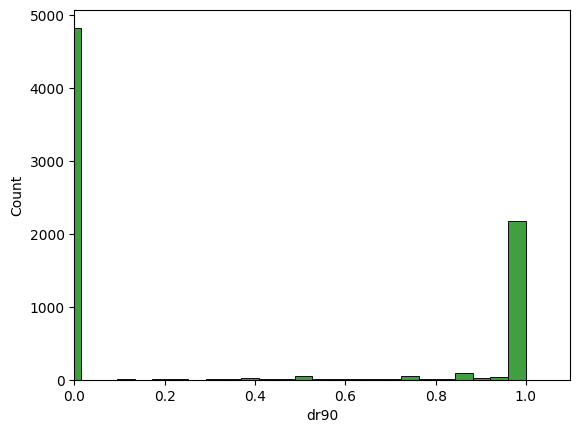

In [15]:
# distribucion del fraude
sns.histplot(df_data["dr90"], bins=50, color="green")
plt.xlim(0, None)   # empieza en 0
plt.show()

Text(0.5, 1.0, 'Distribución del amount de los creditos (log scaled)')

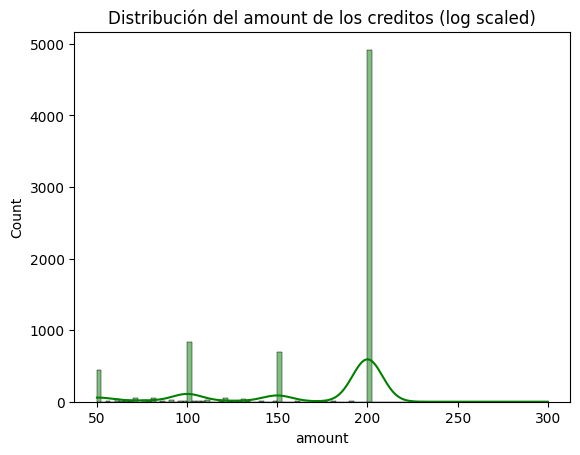

In [16]:
sns.histplot(df_data["amount"], bins=100, kde=True, color="green")
plt.title("Distribución del amount de los creditos (log scaled)")

tramo_phone_first_seen_days (0.5258865764352204, 0.05177315287044082)
phone_first_seen_days (0.5303673365761942, 0.06073467315238834)


,tramo_phone_first_seen_days,count
0,1-1700 días,2502
1,1701-1800 días,2280
2,0 días,1776
3,más de 1800 días,848


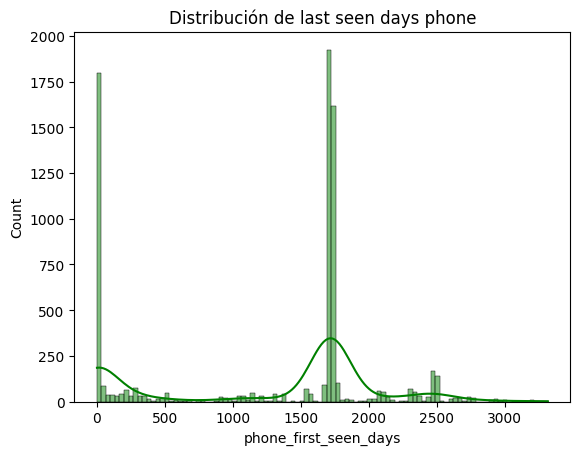

In [17]:
sns.histplot(df_data["phone_first_seen_days"], bins=100, kde=True, color="green")
plt.title("Distribución de last seen days phone")

bins = [-1, 0, 1700, 1800, float('inf')]
labels = [
    "0 días",
    "1-1700 días",
    "1701-1800 días",
    "más de 1800 días"
]

df_data['tramo_phone_first_seen_days'] = pd.cut(
    df_data['phone_first_seen_days'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

df_count = df_data['tramo_phone_first_seen_days'].value_counts().reset_index()
print("tramo_phone_first_seen_days", auc_gini(df_data, "tramo_phone_first_seen_days", "dr90"))
print("phone_first_seen_days",auc_gini(df_data, "phone_first_seen_days", "dr90"))
df_count


In [18]:
df_data["tramo_email_first_seen_days"] = pd.qcut(df_data.loc[df_data["email_first_seen_days"]>0,"email_first_seen_days"], q=3, duplicates='drop')

df_count = df_data['tramo_email_first_seen_days'].value_counts().reset_index()
df_count

bins = [-1, 0, 1959,  2504, float('inf')]
labels = [
    "0 días",
    "1-1959 días",
    "1960-2504 días",
    "más de 2504 días",
]

df_data['tramo_email_first_seen_days'] = pd.cut(
    df_data['email_first_seen_days'],
    bins=bins,
    labels=labels,
    include_lowest=True
)


df_count = df_data['tramo_email_first_seen_days'].value_counts().reset_index()
print("tramo_email_first_seen_days", auc_gini(df_data, "tramo_email_first_seen_days", "dr90"))
print("email_first_seen_days",auc_gini(df_data, "email_first_seen_days", "dr90"))
df_count


tramo_email_first_seen_days (0.5360714215338828, 0.07214284306776553)
email_first_seen_days (0.5408391323214594, 0.08167826464291883)


,tramo_email_first_seen_days,count
0,0 días,2580
1,1960-2504 días,1635
2,1-1959 días,1628
3,más de 2504 días,1563


### Creación variables Trustfull

In [19]:
# Creación de la variable mum total plataformas 
lst_cols_trust = [
    'phone_has_whatsapp', 'phone_has_instagram', 'phone_has_aliexpress',
    'phone_has_telegram', 'phone_has_twitter', 'phone_has_weibo',
    'email_has_spotify', 'email_has_linkedin', 'email_has_deliveroo',
    'email_has_pinterest', 'email_has_wordpress', 'email_has_hubspot',
    'email_has_gravatar', 'email_has_atlassian', 'email_has_lastpass',
    'email_has_adobe', 'email_has_freelancer', 'email_has_github',
    'email_has_disney_plus', 'email_has_google', 'email_has_duolingo',
    'has_facebook', 'has_apple', 'has_amazon', 'has_office365'
]

bins = [ 0, 6, 8, 10, 12, 20]

labels = [
    "0-6 platforms",
    "7-8 platforms",
    "9-10 platforms",
    "11-12 platforms",
    "13-20 platforms"
]

df_data = calculate_num_platforms(df_data, lst_cols_trust, "num_total_plataformas")
df_data = calculate_tramo_creation(df_data, "num_total_plataformas", bins, labels, "tramo_platforms")

df_data["tramo_platforms"].value_counts().reset_index()


,tramo_platforms,count
0,9-10 platforms,2011
1,11-12 platforms,2001
2,13-20 platforms,1733
3,7-8 platforms,1204
4,0-6 platforms,455


In [20]:
# Redes sociales de comunicación 
lst_cols_comunication = [
    'phone_has_whatsapp', 'phone_has_instagram', 
    'phone_has_telegram', 'phone_has_twitter', 'phone_has_weibo',
    'email_has_pinterest'
]

bins = [-0.1, 1, 2, 3, 4, 6]

labels = [
    "0-1 plataformas",
    "2 plataformas",
    "3 plataformas",
    "4 plataformas",
    "5-6 plataformas"
]

df_data = calculate_num_platforms(df_data, lst_cols_comunication, "num_plataformas_comunicacion")
df_data = calculate_tramo_creation(df_data, "num_plataformas_comunicacion", bins, labels, "tramo_platforms_com")

df_data["tramo_platforms_com"].value_counts().reset_index()

,tramo_platforms_com,count
0,4 plataformas,2403
1,3 plataformas,2319
2,5-6 plataformas,1196
3,2 plataformas,1143
4,0-1 plataformas,345


In [21]:
# Plataformas comerciales 
lst_cols_comercial = [
    'phone_has_aliexpress','email_has_spotify', 'email_has_deliveroo',
    'email_has_disney_plus',  'email_has_duolingo', 'has_amazon'
]

# bins = [0,1,2,3,6]
# labels = [
#     "0-1 plat. comerciales",
#     "2 plat. comerciales",
#     "3 plat. comerciales",
#     "4-6 plat. comerciales",
# ]

bins = [-1,0,1,2,3,8]
labels = [
    "0 plat. network/tools",
    "1 plat. network/tools",
    "2 plat. network/tools",
    "3 plat. network/tools",
    "4-8 plat. network/tools",    
]


df_data = calculate_num_platforms(df_data, lst_cols_comercial, "num_plataformas_comercial")
df_data = calculate_tramo_creation(df_data, "num_plataformas_comercial", bins, labels, "tramo_platforms_comercial")

df_data["tramo_platforms_comercial"].value_counts().reset_index()

,tramo_platforms_comercial,count
0,3 plat. network/tools,2360
1,2 plat. network/tools,2136
2,4-8 plat. network/tools,2010
3,1 plat. network/tools,795
4,0 plat. network/tools,105


In [22]:
lst_cols_network_tools = [
    'email_has_linkedin', 'email_has_wordpress', 'email_has_hubspot',
    'email_has_atlassian', 'email_has_adobe', 'email_has_freelancer',
    'email_has_github', 'has_office365'
]

bins = [-1,0,1,2,3,8]
labels = [
    "0 plat. network/tools",
    "1 plat. network/tools",
    "2 plat. network/tools",
    "3 plat. network/tools",
    "4-8 plat. network/tools",    
]

# df_data = calculate_num_platforms(df_data, lst_cols_comercial, "num_professional_network_tools")
df_data = calculate_num_platforms(df_data, lst_cols_network_tools, "num_professional_network_tools")
df_data = calculate_tramo_creation(df_data, "num_professional_network_tools", bins, labels, "tramo_platforms_network_tools")

df_data["tramo_platforms_network_tools"].value_counts().reset_index()

,tramo_platforms_network_tools,count
0,2 plat. network/tools,2544
1,3 plat. network/tools,1997
2,1 plat. network/tools,1674
3,4-8 plat. network/tools,745
4,0 plat. network/tools,446


In [23]:
df_data[["tramo_platforms_network_tools"]].iloc[[4]]
df_data[lst_cols_network_tools].iloc[[4]]

,email_has_linkedin,email_has_wordpress,email_has_hubspot,email_has_atlassian,email_has_adobe,email_has_freelancer,email_has_github,has_office365
39,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [24]:
(
    df_data[["num_professional_network_tools", "tramo_platforms_network_tools"]]
    .value_counts()
    .reset_index(name="count")
    .sort_values("num_professional_network_tools")
)


,num_professional_network_tools,tramo_platforms_network_tools,count
4,0,0 plat. network/tools,446
2,1,1 plat. network/tools,1674
0,2,2 plat. network/tools,2544
1,3,3 plat. network/tools,1997
3,4,4-8 plat. network/tools,526
5,5,4-8 plat. network/tools,155
6,6,4-8 plat. network/tools,47
7,7,4-8 plat. network/tools,16
8,8,4-8 plat. network/tools,1


In [25]:
lst_good_behavioural_apps = [
    "email_has_deliveroo", "has_office365",
    "has_amazon", "email_has_wordpress", "email_has_github",
    "email_has_freelancer", "email_has_adobe", "email_has_hubspot",
    "email_has_pinterest", "email_has_duolingo"
]

bins = [0, 1, 2, 3, 4, 9]
labels = [
    "0-1 plataformas",
    "2 plataformas",
    "3 plataformas",
    "4 plataformas",
    "5-9 plataformas",
]

df_data = calculate_num_platforms(df_data, lst_cols_comercial, "num_total_good_plataformas")
df_data = calculate_tramo_creation(df_data, "num_total_good_plataformas", bins, labels, "tramo_good_behavioral_apps")

df_data["tramo_good_behavioral_apps"].value_counts().reset_index()

,tramo_good_behavioral_apps,count
0,3 plataformas,2360
1,2 plataformas,2136
2,4 plataformas,1484
3,0-1 plataformas,900
4,5-9 plataformas,526


In [26]:
lst_cols_identity = [
    'email_has_gravatar', 'email_has_google',
    'has_facebook', 'has_apple'
]

bins = [-1,1,2,4]
labels = [
    "0-1 plat. identidad",
    "2 plat. identidad",
    "3-4 plat. identidad"
]

df_data = calculate_num_platforms(df_data, lst_cols_comercial, "num_total_good_plataformas")
df_data = calculate_tramo_creation(df_data, "num_total_good_plataformas", bins, labels, "tramo_platforms_identity")

In [27]:
WEIGHTS = {
    "comunication": 0.5,
    "comercial": 1.0,
    "identity": 0.5,
    "network_tools": 1.1
}


col_weights = {}

for col in lst_cols_trust:
    if col in lst_cols_comunication:
        col_weights[col] = WEIGHTS["comunication"]
    elif col in lst_cols_comercial:
        col_weights[col] = WEIGHTS["comercial"]
    elif col in lst_cols_identity:
        col_weights[col] = WEIGHTS["identity"]
    elif col in lst_cols_network_tools:
        col_weights[col] = WEIGHTS["network_tools"]
    else:
        col_weights[col] = 0.0

weights = pd.Series(col_weights)

df_data["digital_presence_score"] = (
    df_data[lst_cols_trust]
    .fillna(0)
    .mul(weights, axis=1)
    .sum(axis=1)
)


In [28]:
def match_2_last_numbers(df):
    lst_phones = df["partials_list_phone"].split(",")

    for phone in lst_phones:
        
        if phone[-2:] == df["cell_phone"][-2:]:
            return 1
    return 0

df_data["partials_list_phone"] = df_data["partials_list_phone"].astype(str)
df_data["same_number"] = df_data[["partials_list_phone", "cell_phone"]].apply(lambda x: match_2_last_numbers(x), axis=1)

In [29]:
def masked_email_match(real_email, masked_email) -> bool:

    if not isinstance(real_email, str) or not isinstance(masked_email, str):
        return False

    real_email = real_email.lower().strip()
    masked_email = masked_email.lower().strip()

    # separamos en los 2-3 componentes que no estan censurados dentro de masked_email
    lst = masked_email.split("*")
    lst_component_email = [x for x in lst if x not in (None, "", [], ".")] 
    is_equal = False
    # print('#'*150)
    # print(f"Email_real: {real_email}")
    # print(f"Masked email: {masked_email}")

    for i, component in enumerate(lst_component_email):
        len_comp = len(component)
        if i == 0: # Comparamos si ambos correos comienzan igual
            # print(f"Nombre: {component} - {real_email[:len_comp]}")
            is_equal = component == real_email[:len_comp]

        elif i == 1:# Comparamos el dominio de ambos correo para ver si coinciden
            find = real_email.find("@")
            # print(f"Find {real_email[find]}")
            # print(f"Dominions: {component} - {real_email[find:(find + len_comp)]}")
            is_equal = component == real_email[find:(find + len_comp)]

        elif i == 2: # Comparamos si el tipo de dominio es el mismo (.com, .es, ...)
            # print(f"Tipo dominio: {component} - {real_email[-len_comp:]}")
            is_equal = component == real_email[-len_comp:]

    return is_equal
    

def match_emails(df):
    lst_emails = df["partials_list_email"].split(",")

    for email in lst_emails:
        if masked_email_match(df["email"], email):
            return 1
    return 0

df_data["partials_list_email"] = df_data["partials_list_email"].astype(str)
df_data["same_email"] = df_data.loc[df_data["partials_list_email"]!='nan',["partials_list_email", "email"]].apply(lambda x:  match_emails(x), axis=1)


In [30]:
df_data["same_email"].value_counts().reset_index()

,same_email,count
0,1.0,1565
1,0.0,101


In [31]:
df_data["email_has_image"].value_counts().reset_index()

,email_has_image,count
0,google,1259
1,gravatar,37
2,social,15


In [32]:
# Imagenes de phone y movil
df_data["email_has_image"] = np.where(df_data["email_has_image"].isna(),0,1)
df_data["email_has_face_image"] = np.where(df_data["email_has_face_image"].isna(), 0, 1)
df_data["phone_has_image"] = np.where(df_data["phone_has_image"].isna(),0,1)
df_data["phone_has_face_image"] = np.where(df_data["phone_has_face_image"].isna(), 0, 1)


In [33]:
# Privacidad de whatsapp
df_data["whatsapp_privacy_status_flag"] = df_data["whatsapp_privacy_status"].astype(str) # Para una variable calculada más adelante
df_data["whatsapp_privacy_status"] = np.where(df_data["whatsapp_privacy_status"].isna(), 0, 1)
df_data["whatsapp_privacy_status"].value_counts(dropna=False).reset_index()

,whatsapp_privacy_status,count
0,1,4071
1,0,3335


In [34]:
df_data["is_whatsapp_business"] = np.where(df_data["is_whatsapp_business"]==True, 1, 0)
df_data["is_whatsapp_business"].value_counts().reset_index()

,is_whatsapp_business,count
0,0,7322
1,1,84


In [35]:
df_data["telegram_privacy_status"] = np.where(df_data["telegram_privacy_status"]=='private', 1, 0)
df_data["telegram_privacy_status"].value_counts().reset_index()

,telegram_privacy_status,count
0,0,5739
1,1,1667


In [36]:
# Coincidencia de nombres 
mask_trust = ~(df_data["phone_first_name"].isna()) & ~(df_data["email_first_name"].isna())
mask_name_phone = ~(df_data["phone_first_name"].isna()) & ~(df_data["first_name"].isna())
mask_name_email = ~(df_data["email_first_name"].isna()) & ~(df_data["first_name"].isna())


df_data["same_name_email_phone"] = df_data[mask_trust][["phone_first_name", "email_first_name"]].apply(
    lambda x: 
        match_names(x["phone_first_name"], x["email_first_name"])
    ,axis=1
)
df_data["same_name_email_database"] = df_data[mask_name_email][["email_first_name", "first_name"]].apply(
    lambda x: 
        match_names(x["email_first_name"], x["first_name"])
    ,axis=1
)
df_data["same_name_phone_database"]= df_data[mask_name_phone][["phone_first_name", "first_name"]].apply(
    lambda x: 
        match_names(x["phone_first_name"], x["first_name"])
    ,axis=1
)

In [37]:

mask_telegram_email=~(df_data["telegram_first_name"].isna()) & ~(df_data["email_first_name"].isna())
mask_telegram_phone=~(df_data["telegram_first_name"].isna()) & ~(df_data["phone_first_name"].isna())
mask_telegram_data=~(df_data["telegram_first_name"].isna()) & ~(df_data["first_name"].isna())
# Telegram
df_data["same_name_telegram_phone"]= df_data[mask_telegram_phone ][["telegram_first_name", "phone_first_name"]].apply(
    lambda x: 
        match_names(x["telegram_first_name"], x["phone_first_name"])
    ,axis=1
)
df_data["same_name_telegram_email"]= df_data[mask_telegram_email][["telegram_first_name", "email_first_name"]].apply(
    lambda x: 
        match_names(x["telegram_first_name"], x["email_first_name"])
    ,axis=1
)
df_data["same_name_telegram_database"]= df_data[mask_telegram_data][["telegram_first_name", "first_name"]].apply(
    lambda x: 
        match_names(x["telegram_first_name"], x["first_name"])
    ,axis=1
)

In [38]:
df_data["same_name_email_phone"].value_counts(dropna=False).reset_index()

,same_name_email_phone,count
0,NaN,5747
1,0.0,975
2,1.0,684


In [39]:
df_data["same_name_email_database"].value_counts(dropna=False).reset_index()

,same_name_email_database,count
0,NaN,5014
1,1.0,1518
2,0.0,874


In [40]:
df_data["same_name_phone_database"].value_counts(dropna=False).reset_index()

,same_name_phone_database,count
0,NaN,4096
1,0.0,2244
2,1.0,1066


In [41]:
def browser_tag(browser):
    if 'safari' in browser.lower():
        return 'Safari'

    if 'chrome' in browser.lower():
        return 'Chrome'

    # if 'edge' in browser.lower():
    #     return 'Edge'

    if ('samsung' in browser.lower()) | ('google' in browser.lower())| ('miui' in browser.lower()):
        return 'Buscadores SO'

    return 'Otros' 
    

# Unificaremos los diferentes buscadores para evitar tener tantos tipos diferentes

df_data["browser_tag"] = df_data["browser_family"].apply(lambda x: browser_tag(x))

In [42]:
lst_col_train = []
# Como los modelos basados en arboels no aceptan variables categoricas mediante Empirical Bayes / Shrinkage daremos un valor de DR a cada banco segun la cantidad de muestras que tenga este.
df_data = shrinkage(df_data, "bank_name")
lst_col_train.append("bank_name_shrinkage")

# Amount
df_data = shrinkage(df_data, "tramo_amount_2")
lst_col_train.append("tramo_amount_2_shrinkage")

# Amount
df_data = shrinkage(df_data, "tramo_amount")
lst_col_train.append("tramo_amount_shrinkage")

# Days
df_data = shrinkage(df_data, "tramo_days")
lst_col_train.append("tramo_days_shrinkage")

# promo_code
lst_col_train.append("promo_code") # variable binaria la añadimos directamente a la lista

# ip_asn_flag
df_data = shrinkage(df_data, "ip_asn_flag")
lst_col_train.append("ip_asn_flag_shrinkage")

# ip_city_flag
df_data = shrinkage(df_data, "ip_city_flag")
lst_col_train.append("ip_city_flag_shrinkage")

# is_apple_realy
lst_col_train.append("is_apple_realy")

# is_nie 
lst_col_train.append("is_nie")

# Os family
df_data = shrinkage(df_data, "os_family")
lst_col_train.append("os_family_shrinkage")


# digital_presence_score PENDIENTE TRUSTFULL
lst_col_train.append("digital_presence_score")

# tramo_breaches_phone PENDIENTE TRUSTFULL
lst_col_train.append("breaches_count_phone")

# tramo_breaches_email PENDIENTE TRUSTFULL
lst_col_train.append("breaches_count_phone")

# num_total_plataformas
lst_col_train.append("num_total_plataformas")
df_data = shrinkage(df_data, "tramo_platforms")
lst_col_train.append("tramo_platforms_shrinkage")

# num_professional_network_tools PENDIENTE TRUSTFULL
lst_col_train.append("num_professional_network_tools")
df_data = shrinkage(df_data, "tramo_platforms_network_tools")
lst_col_train.append("tramo_platforms_network_tools_shrinkage")

# tramo_good_behavioral_apps PENDIENTE TRUSTFULL
lst_col_train.append("num_total_good_plataformas")
df_data = shrinkage(df_data, "tramo_good_behavioral_apps")
lst_col_train.append("tramo_good_behavioral_apps_shrinkage")

# tramo_platforms_comercial 
lst_col_train.append("num_plataformas_comercial")
df_data = shrinkage(df_data, "tramo_platforms_comercial")
lst_col_train.append("tramo_platforms_comercial_shrinkage")

lst_has_cols = [x for x in df_data.columns.to_list() if 'has' in x]

lst_col_train += lst_has_cols

# tramos_email first seeen and phone first seen
df_data = shrinkage(df_data, "tramo_email_first_seen_days")
lst_col_train.append("tramo_email_first_seen_days_shrinkage")
df_data = shrinkage(df_data, "tramo_phone_first_seen_days")
lst_col_train.append("tramo_email_first_seen_days_shrinkage")


# Variable de buscador 
# df_data = shrinkage(df_data, "browser_tag")
# lst_col_train.append("browser_tag_shrinkage")


# Variable whatsapp_privacy_status_shrinkage (dependiendo si es 0, 1 o Nan)
# df_data = shrinkage(df_data, "whatsapp_privacy_status_flag")
# lst_col_train.append("whatsapp_privacy_status_flag_shrinkage")


C:\Users\Carlos\AppData\Local\Temp\ipykernel_15772\3707404581.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(var)[dr].mean().reset_index()
C:\Users\Carlos\AppData\Local\Temp\ipykernel_15772\3707404581.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(var)[dr].mean().reset_index()
C:\Users\Carlos\AppData\Local\Temp\ipykernel_15772\3707404581.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and s

In [43]:
dct_columns = {
    "bank_name": "bank_name_shrinkage",
    "tramo_amount_2": "tramo_amount_2_shrinkage",
    "tramo_days": "tramo_days_shrinkage",
    "ip_asn_flag": "ip_asn_flag_shrinkage",
    "ip_city_flag": "ip_city_flag_shrinkage",
    "os_family": "os_family_shrinkage",
    "tramo_platforms":"tramo_platforms_shrinkage",
    "tramo_platforms_network_tools":"tramo_platforms_network_tools_shrinkage",
    "tramo_good_behavioral_apps":"tramo_good_behavioral_apps_shrinkage",
    "tramo_platforms_comercial":"tramo_platforms_comercial_shrinkage"
}

for key,val in dct_columns.items():

    df_data[[key, val]]

    df_count = df_data[[key, val]].value_counts().reset_index()

    df_count = df_count[[key, val]]
    df_count.to_csv(f"../data/datos/{val}.csv", index=False)
df_count

,tramo_platforms_comercial,tramo_platforms_comercial_shrinkage
0,3 plat. network/tools,0.461063
1,2 plat. network/tools,0.491701
2,4-8 plat. network/tools,0.477902
3,1 plat. network/tools,0.766330
4,0 plat. network/tools,3.506466


In [44]:
import sys
from pathlib import Path

# sube hasta encontrar la carpeta 'src'
p = Path.cwd()
while p.name != "src" and p != p.parent:
    p = p.parent
    print(p, p.parent)

if p.name != "src":
    raise RuntimeError("No se encontró la carpeta 'src'")

sys.path.insert(0, str(p))
print("Añadido al sys.path:", p)

c:\Users\Carlos\Documents\Fraud-Model\src c:\Users\Carlos\Documents\Fraud-Model
Añadido al sys.path: c:\Users\Carlos\Documents\Fraud-Model\src


In [45]:
df_count = df_data["fraud"].value_counts().reset_index()
df_count["peso"] = round(df_count["count"] / df_data.shape[0], 2)
df_count

,fraud,count,peso
0,0,5703,0.77
1,1,1703,0.23


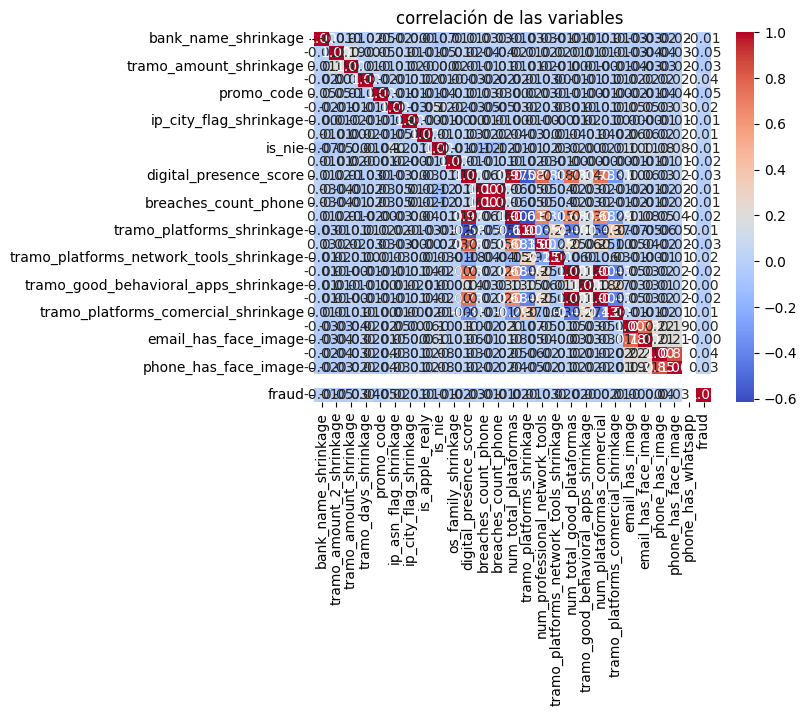

In [46]:
df_corr = df_data[lst_col_train[:len(lst_col_train)//2] + ["fraud"]].select_dtypes(include="number")
corr = df_corr.corr()

#corr = df_data[["amount", "days", "bank_name_shrinkage", "promo_code", "ip_asn_flag_shrinkage", "ip_city_flag_shrinkage", "is_apple_realy", "is_nie", "dr90"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("correlación de las variables ")
plt.show()

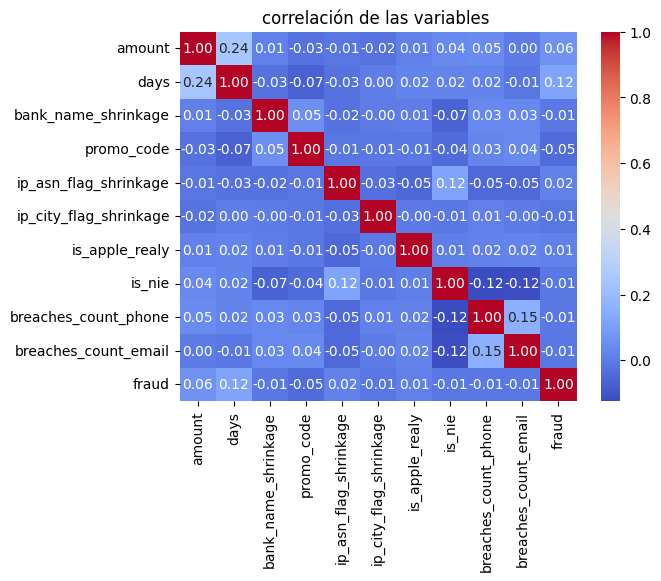

In [47]:
# df_corr = df_data[lst_col_train[len(lst_col_train)//2:] + ["dr90"]].select_dtypes(include="number")
# corr = df_corr.corr()

corr = df_data[
    [
        "amount", "days", "bank_name_shrinkage",
        "promo_code", "ip_asn_flag_shrinkage",
        "ip_city_flag_shrinkage", "is_apple_realy",
        "is_nie", "breaches_count_phone", "breaches_count_email",
        "fraud"
        ]
].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("correlación de las variables ")
plt.show()

### Creción variables extra

In [48]:
# lst_cols_attempts = ["dni", "cell_phone", "email"]

# attempt_sets = {c: set(df_attempts[c].dropna().astype(str)) for c in lst_cols_attempts}

# df_data["previous_attempts"] = (
#     df_data[lst_cols_attempts]
#     .astype(str)
#     .apply(lambda s: s.isin(attempt_sets[s.name]), axis=0)
#     .any(axis=1)
#     .astype(int)
# )
# df_data["previous_attempts"].value_counts().reset_index()

In [49]:

# df_data["created_at"] = pd.to_datetime(df_data["created_at"]).dt.strftime("%Y-%m-%d")

# df_data["diff_days"] = df_data["created_at"] - df_attempts["created_at"]

In [50]:
df_data["dni"].values

array(['Y2691765C', '49721341X', '07251317S', ..., '49597729T',
       '72504987V', '41745778L'], shape=(7406,), dtype=object)

## Modelos
### XGBoost

In [ ]:
# (COMBINACIÓN DE VARIABLES QUE POR EL MOMENTO RINDE MEJOR)
lst_col_train = [
'bank_name_shrinkage', # Lista
'tramo_amount_2_shrinkage', # Lista
'tramo_days_shrinkage', # Lista
'promo_code', # Lista (has_information_flag)
'ip_asn_flag_shrinkage', # Lista
'os_family_shrinkage', # Lista
'digital_presence_score', # Lista
'breaches_count_email', # Lista (sin cambios)
'breaches_count_phone', # Lista (sin cambios)
'tramo_platforms_comercial_shrinkage', # Lista
'has_amazon',# Lista 
'same_number',# Lista
'phone_has_twitter', # Lista
'same_email', # Lista (match_emails)
'email_has_image', # Lista
'whatsapp_privacy_status', # Lista (has_information_flag)
'same_name_email_phone', # Lista (match_names)
'same_name_email_database', # Lista (match_names)
'same_name_phone_database', # Lista (match_names)
'phone_first_seen_days', # Lista (sin cambios)
'email_first_seen_days', # Lista (sin cambios)
'phone_has_telegram', # Lista
'tramo_platforms_network_tools_shrinkage',
'is_whatsapp_business', # Lista
'telegram_privacy_status',  # Lista
'email_has_pinterest',  # Lista

'email_has_google',
]

lst_ordered_cols = [
    'tramo_days_shrinkage',
    'bank_name_shrinkage',
    'email_first_seen_days',
    'digital_presence_score',
    'num_total_plataformas',
    'email_has_duolingo',
    'tramo_amount_2_shrinkage',
    'breaches_count_email',
    'os_family_shrinkage',
    'phone_first_seen_days',
    'whatsapp_privacy_status',
    'has_apple',
    # 'tramo_platforms_shrinkage',
    'same_name_phone_database',
    'ip_asn_flag_shrinkage',
    'same_number',
    'email_has_pinterest',
    'tramo_platforms_network_tools_shrinkage',
    'promo_code',
    'email_has_wordpress',
    # 'num_professional_network_tools',
    'has_facebook',
    'breaches_count_phone',
    'same_name_email_database',
    'has_amazon',
    'is_nie',
    'phone_has_instagram',
    'telegram_privacy_status',
    'same_name_email_phone',
    'tramo_good_behavioral_apps_shrinkage',
    'email_has_disney_plus',
    'same_email',
    'email_has_linkedin',
    'has_office365',
    # 'num_total_good_plataformas',
    'email_has_face_image',
    'phone_has_telegram',
    'phone_has_aliexpress',
    'ip_city_flag_shrinkage',
    'phone_has_face_image',
    'email_has_google',
    'email_has_spotify',
    # 'num_plataformas_comercial',
    'email_has_image',
    'email_has_deliveroo',
    'phone_has_twitter',
    'email_has_adobe',
    'phone_has_image',
    'tramo_platforms_comercial_shrinkage',
    'email_has_atlassian',
    'email_has_github',
    'is_apple_realy',
    'email_has_freelancer',
    'email_has_lastpass',
    'phone_has_weibo',
    'email_has_hubspot',
    'email_has_gravatar',
    'is_whatsapp_business'
 ]


In [361]:
lst_col_train

['bank_name_shrinkage',
 'tramo_amount_2_shrinkage',
 'tramo_days_shrinkage',
 'promo_code',
 'ip_asn_flag_shrinkage',
 'os_family_shrinkage',
 'digital_presence_score',
 'breaches_count_email',
 'breaches_count_phone',
 'tramo_platforms_comercial_shrinkage',
 'has_amazon',
 'same_number',
 'phone_has_twitter',
 'same_email',
 'email_has_image',
 'whatsapp_privacy_status',
 'same_name_email_phone',
 'same_name_email_database',
 'same_name_phone_database',
 'phone_first_seen_days',
 'email_first_seen_days',
 'phone_has_telegram',
 'tramo_platforms_network_tools_shrinkage',
 'is_whatsapp_business',
 'telegram_privacy_status',
 'email_has_pinterest',
 'phone_has_face_image']

In [362]:
len(lst_col_train)

27

In [363]:
lst_final_cols = lst_col_train
#lst_final_cols = lst_ordered_cols

X = df_data[lst_final_cols].copy()
y = df_data["fraud"].astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)
# recuperamos los usuarios de test
df_test = df_data.loc[X_test.index].copy()

X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()


In [364]:
from xgboost import XGBRegressor

model = XGBRegressor(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    device="cpu",

    n_estimators=5000,          # alto + early stopping decide
    learning_rate=0.05,         # más bajo = más suave

    max_depth=3,                # menos profundidad
    min_child_weight=50,        # evita splits con pocos casos
    gamma=1.0,                  # penaliza splits “poco útiles”

    subsample=0.75,             # más aleatoriedad (menos overfit)
    colsample_bytree=0.45,      # cada árbol ve menos features

    reg_alpha=0.5,              # L1
    reg_lambda=10.0,            # L2

    random_state=1,
    early_stopping_rounds=200
)

weights = np.where(y_train == 1, (0.77/0.23), 1)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True,
    sample_weight=weights,
)

y_pred = model.predict(X_test)

# seguridad numérica
y_pred = np.clip(y_pred, 0, 1)


best_auc = model.best_score
best_iter = model.best_iteration

print(f"Best AUC (validation): {best_auc:.4f}")
print(f"Best iteration: {best_iter}")

[0]	validation_0-logloss:0.69137
[1]	validation_0-logloss:0.69058
[2]	validation_0-logloss:0.69009
[3]	validation_0-logloss:0.68881
[4]	validation_0-logloss:0.68709
[5]	validation_0-logloss:0.68677
[6]	validation_0-logloss:0.68641
[7]	validation_0-logloss:0.68570
[8]	validation_0-logloss:0.68524
[9]	validation_0-logloss:0.68471
[10]	validation_0-logloss:0.68329
[11]	validation_0-logloss:0.68350
[12]	validation_0-logloss:0.68263
[13]	validation_0-logloss:0.68140
[14]	validation_0-logloss:0.68095
[15]	validation_0-logloss:0.67978
[16]	validation_0-logloss:0.67918
[17]	validation_0-logloss:0.67800
[18]	validation_0-logloss:0.67814
[19]	validation_0-logloss:0.67742
[20]	validation_0-logloss:0.67674
[21]	validation_0-logloss:0.67647
[22]	validation_0-logloss:0.67617
[23]	validation_0-logloss:0.67536
[24]	validation_0-logloss:0.67493
[25]	validation_0-logloss:0.67471
[26]	validation_0-logloss:0.67473
[27]	validation_0-logloss:0.67407


[28]	validation_0-logloss:0.67365
[29]	validation_0-logloss:0.67371
[30]	validation_0-logloss:0.67370
[31]	validation_0-logloss:0.67302
[32]	validation_0-logloss:0.67312
[33]	validation_0-logloss:0.67299
[34]	validation_0-logloss:0.67306
[35]	validation_0-logloss:0.67293
[36]	validation_0-logloss:0.67296
[37]	validation_0-logloss:0.67271
[38]	validation_0-logloss:0.67279
[39]	validation_0-logloss:0.67262
[40]	validation_0-logloss:0.67210
[41]	validation_0-logloss:0.67138
[42]	validation_0-logloss:0.67114
[43]	validation_0-logloss:0.67062
[44]	validation_0-logloss:0.67061
[45]	validation_0-logloss:0.67102
[46]	validation_0-logloss:0.67077
[47]	validation_0-logloss:0.67049
[48]	validation_0-logloss:0.67038
[49]	validation_0-logloss:0.67009
[50]	validation_0-logloss:0.66951
[51]	validation_0-logloss:0.66974
[52]	validation_0-logloss:0.66944
[53]	validation_0-logloss:0.66942
[54]	validation_0-logloss:0.66943
[55]	validation_0-logloss:0.66905
[56]	validation_0-logloss:0.66912
[57]	validatio

In [365]:
#lst_quant = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98]
lst_quant = [0.95]


for quant in lst_quant:
    print("#"*150)
    print("#"*150)
    threshold = np.quantile(y_pred, quant)

    y_pred_bin = (y_pred >= threshold).astype(int)

    auc = roc_auc_score(y_test, y_pred)
    precision_10 = precision_score(y_test, y_pred_bin)
    recall_10 = recall_score(y_test, y_pred_bin)
    f1 = f1_score(y_test, y_pred_bin)

    y_train_auc = model.predict(X_train)
    auc_train = roc_auc_score(y_train, y_train_auc)

    pct_flagged = (1 - quant) * 100
    diff_auc = auc_train - auc

    print(f"threshold for fraud detection: {threshold:.6f}")
    print(f"Policy: flag the top {pct_flagged:.2f}% most risky profiles")

    print(f"AUC Train: {auc_train:.4f}")
    print(f"AUC Test: {auc:.4f}")
    print(f"Diferencia train test AUC: {diff_auc:.3f}")
    print(f"Precision@%: {precision_10:.3f}")
    print(f"Recall@%: {recall_10:.3f}")
    print(f"F1-score: {f1:.3f}")
    
    

######################################################################################################################################################
######################################################################################################################################################


threshold for fraud detection: 0.723118
Policy: flag the top 5.00% most risky profiles
AUC Train: 0.7898
AUC Test: 0.6164
Diferencia train test AUC: 0.173
Precision@%: 0.400
Recall@%: 0.088
F1-score: 0.144


In [316]:
lst_final_cols

['bank_name_shrinkage',
 'tramo_amount_2_shrinkage',
 'tramo_days_shrinkage',
 'promo_code',
 'ip_asn_flag_shrinkage',
 'os_family_shrinkage',
 'digital_presence_score',
 'breaches_count_email',
 'breaches_count_phone',
 'tramo_platforms_comercial_shrinkage',
 'has_amazon',
 'same_number',
 'phone_has_twitter',
 'same_email',
 'email_has_image',
 'whatsapp_privacy_status',
 'same_name_email_phone',
 'same_name_email_database',
 'same_name_phone_database',
 'phone_first_seen_days',
 'email_first_seen_days',
 'phone_has_telegram',
 'tramo_platforms_network_tools_shrinkage',
 'is_whatsapp_business',
 'telegram_privacy_status',
 'email_has_pinterest']

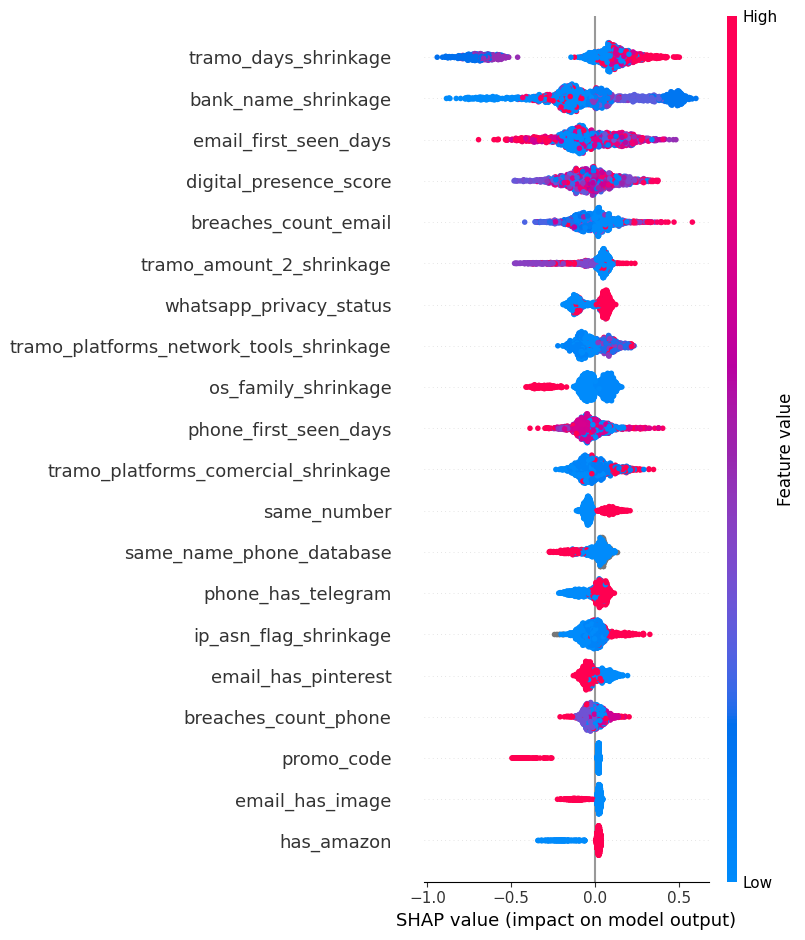

In [317]:
import shap

# 1️⃣ Asegura NumPy para SHAP
X_test_np = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_np)

# 2️⃣ Reconstruye DataFrame SOLO para el plot
X_test_df = pd.DataFrame(
    X_test_np,
    columns=lst_final_cols  # o X_train.columns si usaste get_dummies
)

# 3️⃣ Plot con nombres correctos
shap.summary_plot(shap_values, X_test_df)

In [318]:

# shap_values: (n_samples, n_features)
mean_abs_shap = np.abs(shap_values).mean(axis=0)

shap_importance = pd.Series(
    mean_abs_shap,
    index=lst_final_cols
).sort_values(ascending=False)

shap_importance

tramo_days_shrinkage                       0.257121
bank_name_shrinkage                        0.228829
email_first_seen_days                      0.149498
digital_presence_score                     0.113188
breaches_count_email                       0.086500
tramo_amount_2_shrinkage                   0.082377
whatsapp_privacy_status                    0.079959
tramo_platforms_network_tools_shrinkage    0.079454
os_family_shrinkage                        0.078365
phone_first_seen_days                      0.073004
tramo_platforms_comercial_shrinkage        0.070500
same_number                                0.059699
same_name_phone_database                   0.057267
phone_has_telegram                         0.056142
ip_asn_flag_shrinkage                      0.055501
email_has_pinterest                        0.052142
breaches_count_phone                       0.042805
promo_code                                 0.041733
email_has_image                            0.040664
has_amazon  

In [319]:
shap_importance.index.tolist()

['tramo_days_shrinkage',
 'bank_name_shrinkage',
 'email_first_seen_days',
 'digital_presence_score',
 'breaches_count_email',
 'tramo_amount_2_shrinkage',
 'whatsapp_privacy_status',
 'tramo_platforms_network_tools_shrinkage',
 'os_family_shrinkage',
 'phone_first_seen_days',
 'tramo_platforms_comercial_shrinkage',
 'same_number',
 'same_name_phone_database',
 'phone_has_telegram',
 'ip_asn_flag_shrinkage',
 'email_has_pinterest',
 'breaches_count_phone',
 'promo_code',
 'email_has_image',
 'has_amazon',
 'phone_has_twitter',
 'same_name_email_phone',
 'same_email',
 'same_name_email_database',
 'telegram_privacy_status',
 'is_whatsapp_business']

0.71687037
######################################################################################################################################################
######################################################################################################################################################

📊 Análisis de variable: fraud_prediction
--------------------------------------------------


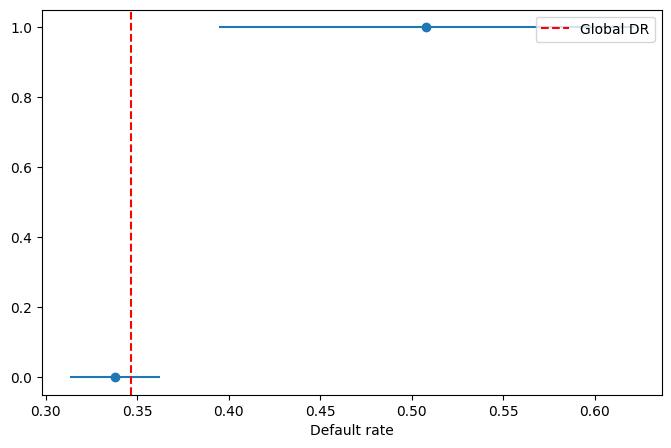

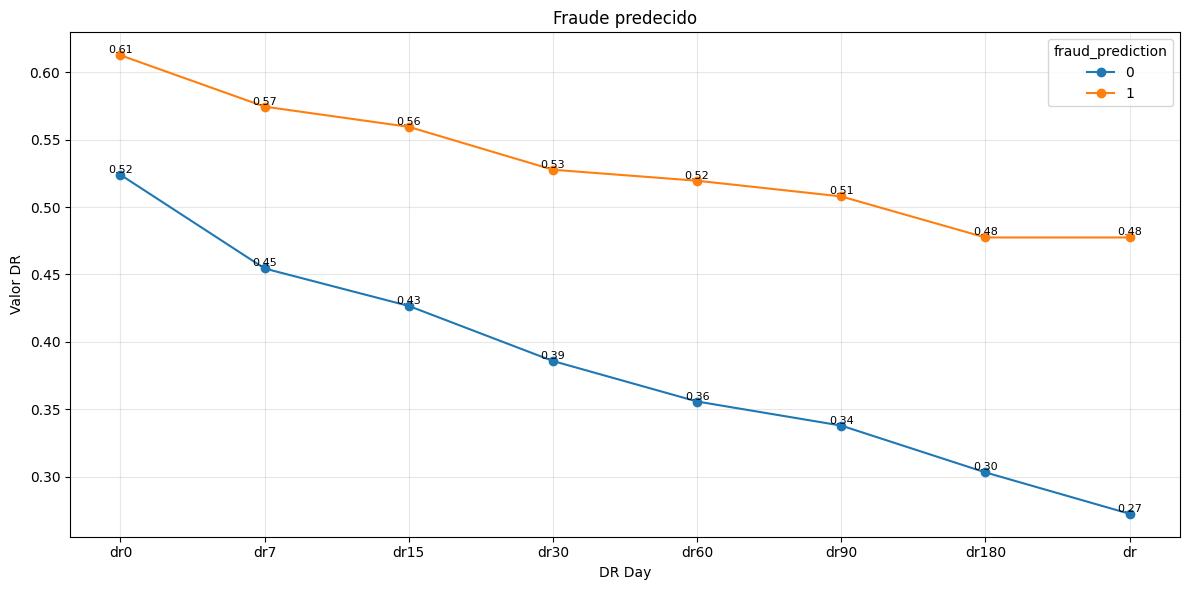

,Model,Vol_con_clusters,Vol_sin_clusters,Profit_con_clusters (€),Profit_sin_clusters (€),Ratio_vol,Diff_profit (€)
1,Modelo actual,1482,1407,-19446.42,-14322.53,0.95,5123.89


In [320]:
X = df_test[lst_final_cols].copy()
y = df_test["fraud"].astype(int)
y_pred_total = model.predict(X)

lst_quant = [0.95]

for quant in lst_quant:
    threshold = np.quantile(y_pred_total, quant)
    print(threshold)
    y_pred_bin = (y_pred_total >= threshold).astype(int)
    df_test["fraud_prediction"] = y_pred_bin

    result = full_analysis_by_var(df_test, "fraud_prediction", 'dr90', "Fraude predecido")

    df_table = calculate_ratios(df_test)
df_table

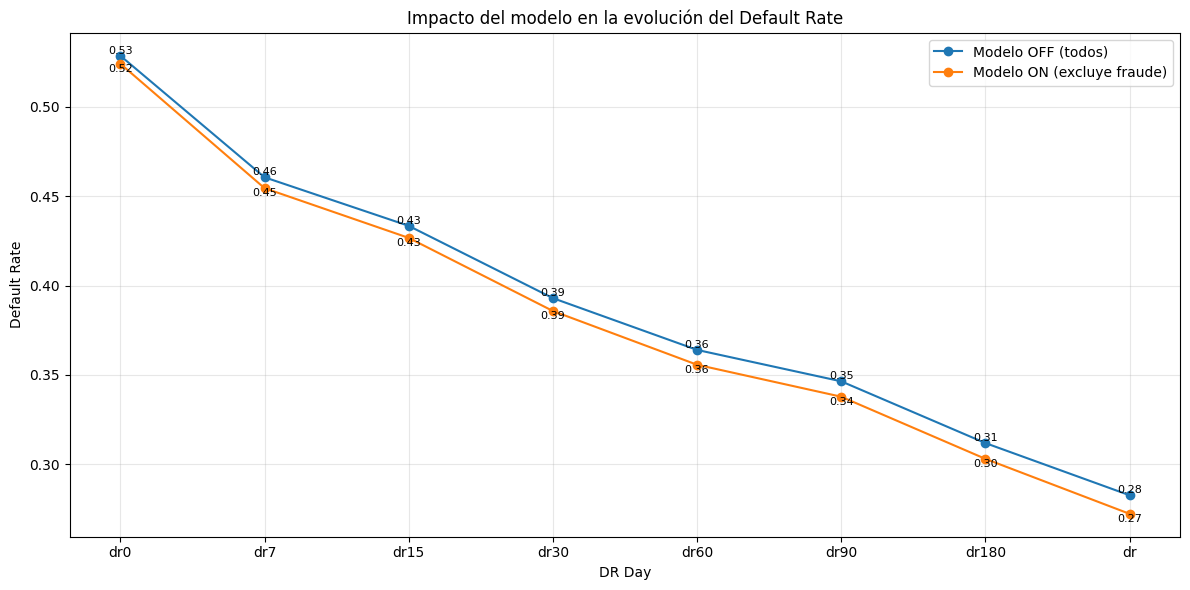

In [321]:
line_plot_model_impact(
    df=df_test,
    fraud_flag_col="fraud_prediction",   # 1 si el modelo marca fraude
    lst_col=["dr0", "dr7", "dr15", "dr30", "dr60", "dr90", "dr180", "dr"]
)

In [61]:
df_test["fraud"].value_counts().reset_index()

,fraud,count
0,0,1141
1,1,341


,fraud,0,score
0,0,43,0.431288
1,1,32,0.757559


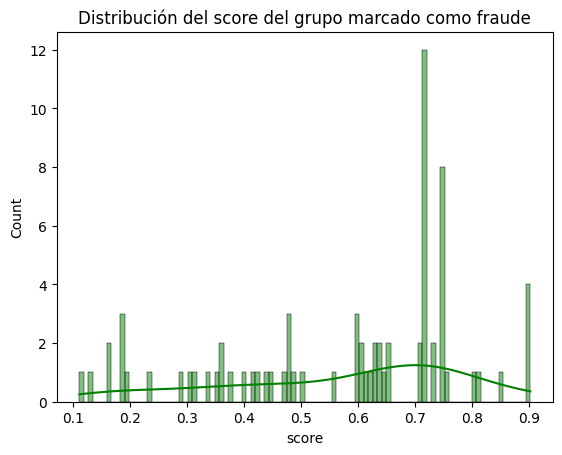

In [62]:
df_test["fraud"] = df_test["fraud"].astype(int)
df_test_count = df_test[df_test["fraud_prediction"]==1].groupby("fraud").size().reset_index()

df_test_mean = df_test[df_test["fraud_prediction"]==1].groupby("fraud")["score"].mean().reset_index()

df_test_count = df_test_count.merge(df_test_mean, on='fraud', how='left')

sns.histplot(df_test.loc[df_test["fraud_prediction"]==1, 'score'], bins=100, kde=True, color="green")
plt.title("Distribución del score del grupo marcado como fraude")
df_test_count

,fraud,0,score
0,0,1098,0.394408
1,1,309,0.787297


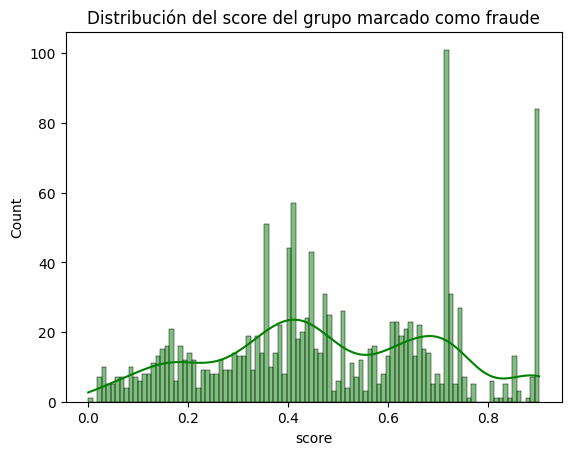

In [63]:
df_test["fraud"] = df_test["fraud"].astype(int)
df_test_count = df_test[df_test["fraud_prediction"]==0].groupby("fraud").size().reset_index()

df_test_mean = df_test[df_test["fraud_prediction"]==0].groupby("fraud")["score"].mean().reset_index()

df_test_count = df_test_count.merge(df_test_mean, on='fraud', how='left')

sns.histplot(df_test.loc[df_test["fraud_prediction"]==0, 'score'], bins=100, kde=True, color="green")
plt.title("Distribución del score del grupo marcado como fraude")
df_test_count

In [64]:
df_mask = df_data[df_data["year_month_of_creation"].isin(["2024-01","2024-02","2024-03","2024-04","2024-05","2025-07","2025-08"])]
df_count= df_mask.groupby("year_month_of_creation")["profit"].sum().reset_index()

df_pred= df_mask[df_mask["fraud_prediction"]==0].groupby("year_month_of_creation")["profit"].sum().reset_index()

df_pred = df_count.merge(df_pred, on="year_month_of_creation", how='left')
df_pred["diff_profit"] = (df_pred["profit_x"] - df_pred["profit_y"]).abs().round(2)
df_pred["profit_x"].sum(), df_pred["profit_y"].sum()
df_pred["ahorro"] =(df_pred["diff_profit"] / df_pred["profit_x"]).abs().round(2)

df_pred

KeyError: 'fraud_prediction'

In [ ]:
df_data["year_month_of_creation"].value_counts().reset_index()

,year_month_of_creation,count
0,2025-08,2037
1,2025-07,2031
2,2024-03,691
3,2024-04,678
4,2024-02,629
5,2024-01,599
6,2024-05,560
7,2024-07,38
8,2024-06,25
9,2024-09,19


threshold for fraud detection: 0.730254
AUC: 0.7634
Precision@10%: 0.660
Recall@10%: 0.144
F1-score: 0.236
######################################################################################################################################################
######################################################################################################################################################

📊 Análisis de variable: fraud_prediction
--------------------------------------------------


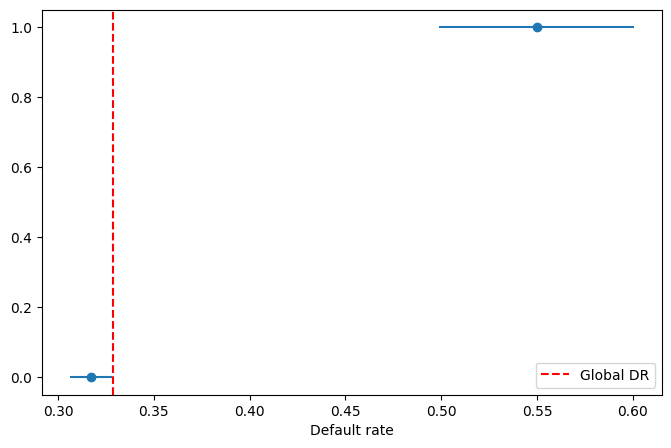

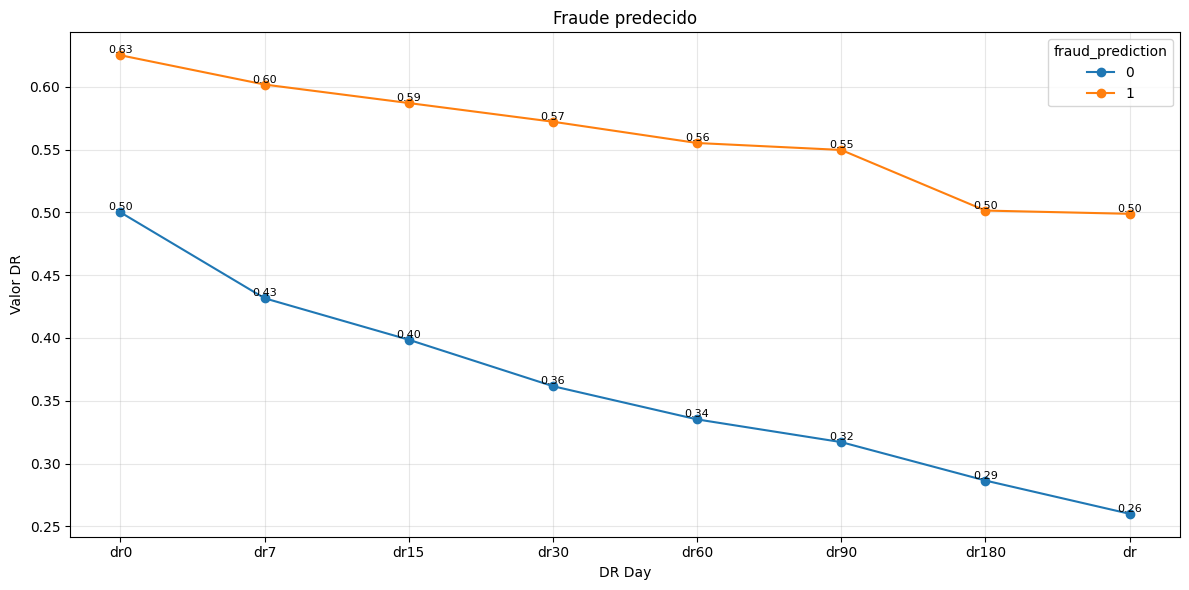

,Model,Vol_con_clusters,Vol_sin_clusters,Profit_con_clusters (€),Profit_sin_clusters (€),Ratio_vol,Diff_profit (€)
1,Modelo actual,7406,7035,-87979.09,-60641.96,0.95,27337.13


In [ ]:
X = df_data[lst_final_cols].copy()
y = df_data["fraud"].astype(int)

y_pred_total = model.predict(X)

threshold = np.quantile(y_pred_total, 0.95)
y_pred_bin = (y_pred_total >= threshold).astype(int)

auc = roc_auc_score(y, y_pred_total)
precision_10 = precision_score(y, y_pred_bin)
recall_10 = recall_score(y, y_pred_bin)
f1 = f1_score(y, y_pred_bin)

print(f"threshold for fraud detection: {threshold:.6f}")

print(f"AUC: {auc:.4f}")
print(f"Precision@10%: {precision_10:.3f}")
print(f"Recall@10%: {recall_10:.3f}")
print(f"F1-score: {f1:.3f}")

df_data["fraud_prediction"] = y_pred_bin

result = full_analysis_by_var(df_data, "fraud_prediction", 'dr90', "Fraude predecido")
result["lift_table"]
df_table = calculate_ratios(df_data)
df_table

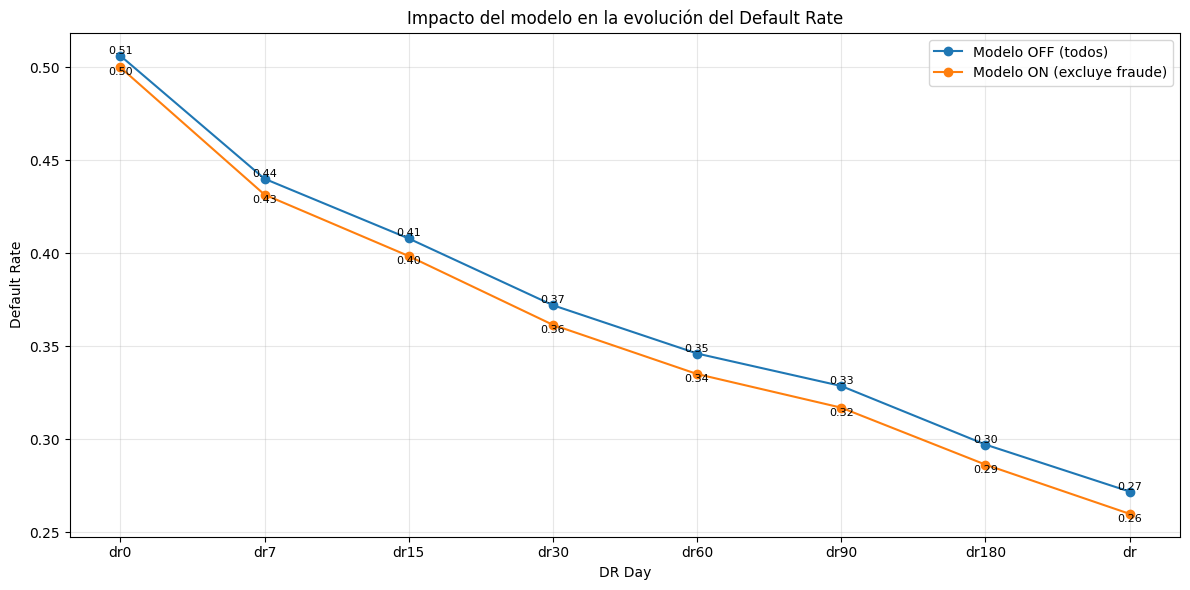

In [ ]:
line_plot_model_impact(
    df=df_data,
    fraud_flag_col="fraud_prediction",   # 1 si el modelo marca fraude
    lst_col=["dr0", "dr7", "dr15", "dr30", "dr60", "dr90", "dr180", "dr"]
)

In [ ]:
df_data.loc[df_data["fraud_prediction"]==1, "ref_id"].to_clipboard(index=False, header=False)

,fraud,0,score
0,0,5564,0.390861
1,1,1469,0.788990


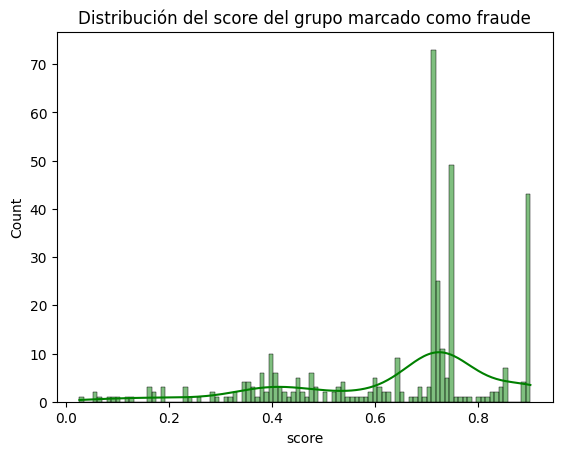

In [ ]:
df_data["fraud"] = df_data["fraud"].astype(int)
df_data_count = df_data[df_data["fraud_prediction"]==0].groupby("fraud").size().reset_index()

df_data_mean = df_data[df_data["fraud_prediction"]==0].groupby("fraud")["score"].mean().reset_index()

df_data_count = df_data_count.merge(df_data_mean, on='fraud', how='left')

sns.histplot(df_data.loc[df_data["fraud_prediction"]==1, 'score'], bins=100, kde=True, color="green")
plt.title("Distribución del score del grupo marcado como fraude")
df_data_count

### XGBoost (randomizedSearch)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform
from sklearn.metrics import make_scorer, fbeta_score



xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    device="cpu",
    random_state=1,
)

param_dist = {
    "n_estimators": randint(500, 8000),
    "learning_rate": loguniform(1e-3, 2e-1),

    "max_depth": randint(2, 8),
    "min_child_weight": randint(1, 80),
    "gamma": uniform(0.0, 5.0),

    "subsample": uniform(0.6, 0.4),         # 0.6–1.0
    "colsample_bytree": uniform(0.4, 0.6),  # 0.4–1.0

    "reg_alpha": loguniform(1e-6, 10.0),
    "reg_lambda": loguniform(1e-2, 200.0),
}

f05_scorer = make_scorer(fbeta_score, beta=0.5)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=80,                 # sube a 200+ si puedes
    scoring=f05_scorer,   # <- aquí      # o "average_precision" (PR-AUC)
    cv=3,
    verbose=2,
    n_jobs=1,
    random_state=1,
)

search.fit(X_train, y_train)

print("Best score:", search.best_score_)
print("Best params:", search.best_params_)
best_model = search.best_estimator_

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] END colsample_bytree=0.6502132028215444, gamma=3.6016224672107904, learning_rate=0.0010006061777325433, max_depth=5, min_child_weight=6, n_estimators=3395, reg_alpha=4.493894149083745e-05, reg_lambda=0.5078150920785492, subsample=0.755164296464803; total time=   3.2s
[CV] END colsample_bytree=0.6502132028215444, gamma=3.6016224672107904, learning_rate=0.0010006061777325433, max_depth=5, min_child_weight=6, n_estimators=3395, reg_alpha=4.493894149083745e-05, reg_lambda=0.5078150920785492, subsample=0.755164296464803; total time=   3.4s
[CV] END colsample_bytree=0.6502132028215444, gamma=3.6016224672107904, learning_rate=0.0010006061777325433, max_depth=5, min_child_weight=6, n_estimators=3395, reg_alpha=4.493894149083745e-05, reg_lambda=0.5078150920785492, subsample=0.755164296464803; total time=   3.2s
[CV] END colsample_bytree=0.801847622082088, gamma=4.677695354030159, learning_rate=0.08859042903822496, max_depth=7, m

KeyboardInterrupt: 

In [ ]:
print("Best score:", search.best_score_)
print("Best params:", search.best_params_)
best_model

Best score: 0.30956358706110626
Best params: {'colsample_bytree': np.float64(0.703397299406138), 'gamma': np.float64(0.10762402637098989), 'learning_rate': np.float64(0.15181262544309382), 'max_depth': 4, 'min_child_weight': 34, 'n_estimators': 2719, 'reg_alpha': np.float64(0.002016433695681962), 'reg_lambda': np.float64(0.028398207890079415), 'subsample': np.float64(0.8012303624480869)}


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,np.float64(0.703397299406138)
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",'cpu'
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.data

In [ ]:
lst_final_cols = lst_col_train


X = df_data[lst_final_cols].copy()
y = df_data["fraud"].astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)
# recuperamos los usuarios de test
df_test = df_data.loc[X_test.index].copy()

X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

best_params = search.best_params_

final_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    device="cpu",
    random_state=1,       # alto
    **best_params
)

weights = np.where(y_train == 1, (0.77/0.23), 1)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True,
    sample_weight=weights,
)


y_pred = final_model.predict(X_test)

# seguridad numérica
y_pred = np.clip(y_pred, 0, 1)

[0]	validation_0-logloss:0.68799
[1]	validation_0-logloss:0.68385
[2]	validation_0-logloss:0.68023
[3]	validation_0-logloss:0.67838
[4]	validation_0-logloss:0.67601
[5]	validation_0-logloss:0.67340
[6]	validation_0-logloss:0.67119
[7]	validation_0-logloss:0.66872
[8]	validation_0-logloss:0.66730
[9]	validation_0-logloss:0.66377
[10]	validation_0-logloss:0.66153
[11]	validation_0-logloss:0.66018
[12]	validation_0-logloss:0.65967
[13]	validation_0-logloss:0.65911
[14]	validation_0-logloss:0.65836
[15]	validation_0-logloss:0.65836


[16]	validation_0-logloss:0.65785
[17]	validation_0-logloss:0.65594
[18]	validation_0-logloss:0.65497
[19]	validation_0-logloss:0.65430
[20]	validation_0-logloss:0.65398
[21]	validation_0-logloss:0.65351
[22]	validation_0-logloss:0.65369
[23]	validation_0-logloss:0.65361
[24]	validation_0-logloss:0.65285
[25]	validation_0-logloss:0.65235
[26]	validation_0-logloss:0.65162
[27]	validation_0-logloss:0.65242
[28]	validation_0-logloss:0.65278
[29]	validation_0-logloss:0.65360
[30]	validation_0-logloss:0.65325
[31]	validation_0-logloss:0.65382
[32]	validation_0-logloss:0.65361
[33]	validation_0-logloss:0.65352
[34]	validation_0-logloss:0.65273
[35]	validation_0-logloss:0.65354
[36]	validation_0-logloss:0.65341
[37]	validation_0-logloss:0.65356
[38]	validation_0-logloss:0.65389
[39]	validation_0-logloss:0.65389
[40]	validation_0-logloss:0.65331
[41]	validation_0-logloss:0.65380
[42]	validation_0-logloss:0.65412
[43]	validation_0-logloss:0.65338
[44]	validation_0-logloss:0.65380
[45]	validatio

In [ ]:
lst_quant = [0.95]


for quant in lst_quant:
    print("#"*150)
    print("#"*150)
    threshold = np.quantile(y_pred, quant)

    y_pred_bin = (y_pred >= threshold).astype(int)

    auc = roc_auc_score(y_test, y_pred)
    precision_10 = precision_score(y_test, y_pred_bin)
    recall_10 = recall_score(y_test, y_pred_bin)
    f1 = f1_score(y_test, y_pred_bin)

    y_train_auc = final_model.predict(X_train)
    auc_train = roc_auc_score(y_train, y_train_auc)

    pct_flagged = (1 - quant) * 100
    diff_auc = auc_train - auc

    print(f"threshold for fraud detection: {threshold:.6f}")
    print(f"Policy: flag the top {pct_flagged:.2f}% most risky profiles")

    print(f"AUC Train: {auc_train:.4f}")
    print(f"AUC Test: {auc:.4f}")
    print(f"Diferencia train test AUC: {diff_auc:.3f}")
    print(f"Precision@10%: {precision_10:.3f}")
    print(f"Recall@10%: {recall_10:.3f}")
    print(f"F1-score: {f1:.3f}")
    

######################################################################################################################################################
######################################################################################################################################################
threshold for fraud detection: 1.000000
Policy: flag the top 5.00% most risky profiles
AUC Train: 0.9655
AUC Test: 0.5564
Diferencia train test AUC: 0.409
Precision@10%: 0.305
Recall@10%: 0.355
F1-score: 0.328


0.69609225
######################################################################################################################################################
######################################################################################################################################################

📊 Análisis de variable: fraud_prediction
--------------------------------------------------


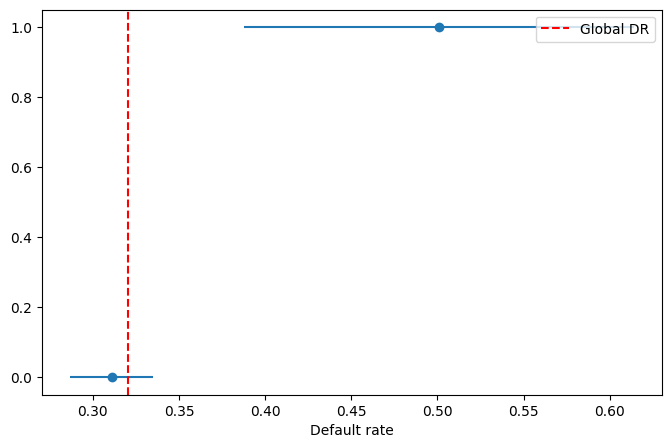

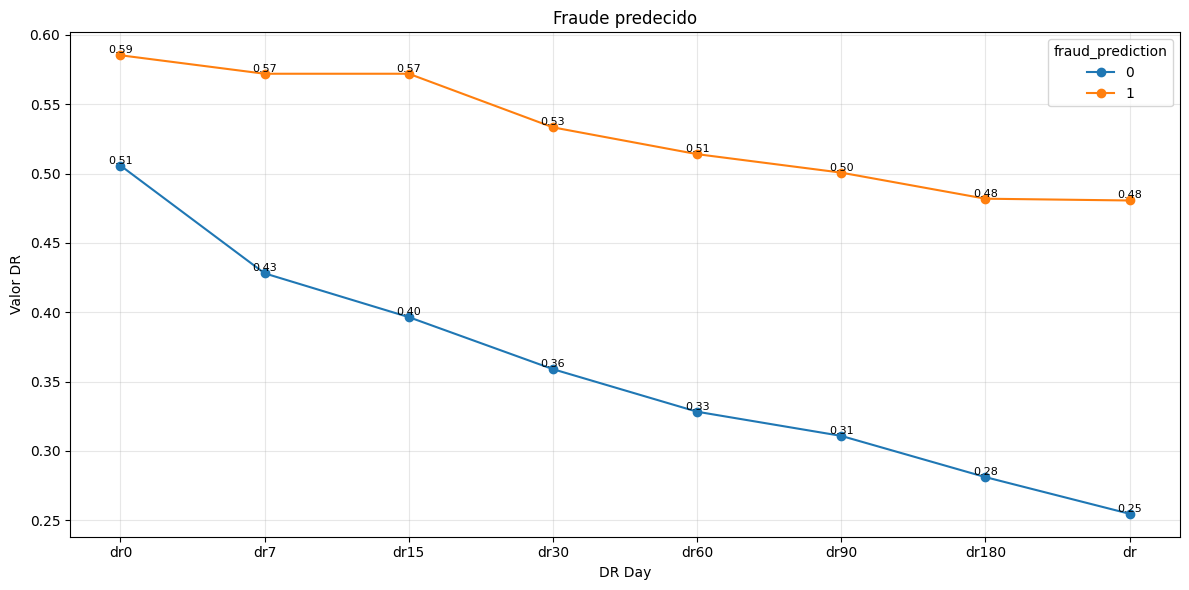

,Model,Vol_con_clusters,Vol_sin_clusters,Profit_con_clusters (€),Profit_sin_clusters (€),Ratio_vol,Diff_profit (€)
1,Modelo actual,1481,1406,-14825.22,-9677.06,0.95,5148.16


In [ ]:
X = df_test[lst_final_cols].copy()
y = df_test["fraud"].astype(int)
y_pred_total = model.predict(X)

lst_quant = [0.95]

for quant in lst_quant:
    threshold = np.quantile(y_pred_total, quant)
    print(threshold)
    y_pred_bin = (y_pred_total >= threshold).astype(int)
    df_test["fraud_prediction"] = y_pred_bin

    result = full_analysis_by_var(df_test, "fraud_prediction", 'dr90', "Fraude predecido")

    df_table = calculate_ratios(df_test)
df_table

### Logistic regresion 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


In [ ]:

lst_cat_cols = ["bank_name", "tramo_days", "tramo_amount_2", "ip_asn_flag", "ip_city_flag", "os_family"]

lst_num_cols = ["digital_presence_score", "breaches_count_phone", "breaches_count_email", "promo_code", "num_professional_network_tools"]
lst_num_cols = lst_col_train

In [ ]:
y = df_data["fraud"]
X = df_data[lst_cat_cols + lst_num_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, stratify=y)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), lst_num_cols),
        ("cat", OneHotEncoder(drop="first"), lst_cat_cols)
    ],
    remainder="drop"
)

In [ ]:
pipeline = Pipeline([
        ("prep", preprocessor),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))   
])

In [ ]:
pipeline.fit(X_train, y_train)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.53      0.65      1140
           1       0.30      0.68      0.42       341

    accuracy                           0.56      1481
   macro avg       0.57      0.60      0.53      1481
weighted avg       0.72      0.56      0.59      1481



In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[600 540]
 [110 231]]


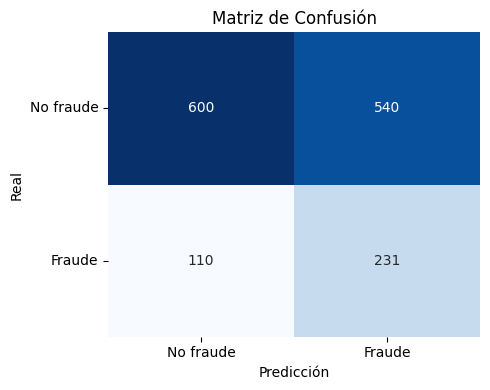

In [ ]:
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False
)

plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.xticks([0.5, 1.5], ["No fraude", "Fraude"])
plt.yticks([0.5, 1.5], ["No fraude", "Fraude"], rotation=0)

plt.tight_layout()
plt.show()

# Final

In [ ]:
df = pd.read_csv("../data/datos/FULL_69690211b29f8-part1.csv")


# De todas las columnas nos quedamos con aquellas que nos interesan
lst_cols_trust = [
    'phone_value', 'email_value', 'phone_data_breaches_count', 'phone_score',
    'phone_score_cluster','phone_has_whatsapp', 'phone_has_instagram', 
    'phone_has_aliexpress','phone_has_telegram', 'phone_has_twitter', 
    'phone_has_weibo',

     "email_data_breaches_count",'email_score', 'email_score_cluster',
    'email_has_spotify', 'email_has_linkedin', 'email_has_deliveroo',
    'email_has_pinterest', 'email_has_wordpress', 'email_has_hubspot',
    'email_has_gravatar', 'email_has_atlassian', 'email_has_lastpass',
    'email_has_adobe', 'email_has_freelancer', 'email_has_github',
    'email_has_disney_plus', 'email_has_google', 'email_has_duolingo',

    'email_has_facebook','phone_has_facebook', 'email_has_apple',
    'phone_has_apple','email_has_amazon', 'phone_has_amazon',
    'email_has_office365','phone_has_office365'
]



df[lst_cols_trust]

C:\Users\Carlos\AppData\Local\Temp\ipykernel_19496\1667901659.py:1: DtypeWarning: Columns (233,254,255,269,270,285,290,313,316,318,319,324,338,341,344,345,350,368,370,371,374,384,385,387,388,399,402,407,412,416,505,510,515,520,553,567,573,575,576,578,579,640) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/datos/FULL_69690211b29f8-part1.csv")


,phone_value,email_value,phone_data_breaches_count,phone_score,phone_score_cluster,phone_has_whatsapp,phone_has_instagram,phone_has_aliexpress,phone_has_telegram,phone_has_twitter,...,email_has_google,email_has_duolingo,email_has_facebook,phone_has_facebook,email_has_apple,phone_has_apple,email_has_amazon,phone_has_amazon,email_has_office365,phone_has_office365
0,34613948665,Tamarit.bl.as29@gmail.com,2,770,high,True,True,False,True,True,...,True,False,False,True,NaN,False,False,True,False,False
1,34617996862,Juanbcerdan@gmail.com,2,757,high,True,True,True,True,True,...,True,True,NaN,False,NaN,False,True,True,False,True
2,34665955693,chemajmlg@gmail.com,1,694,high,True,NaN,False,True,False,...,True,False,False,NaN,False,NaN,True,True,False,False
3,34631416651,M3805457@gmail.com,0,506,review,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,True
4,34647380458,anvicard@gmail.com,1,757,high,True,True,False,True,False,...,True,False,False,True,True,NaN,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4923,34678080340,veces_adulador.0y@icloud.com,3,707,high,True,True,True,True,False,...,False,False,False,False,False,True,False,False,False,False
4924,34667425369,carliitoss17@gmail.com,1,730,high,True,True,False,False,False,...,True,True,NaN,False,True,False,False,False,True,True
4925,34627101182,estarlin161@gmail.com,1,757,high,True,False,False,True,False,...,True,False,True,True,True,True,True,True,True,True
4926,34638410255,krmgravesande@gmail.com,2,743,high,True,NaN,False,False,False,...,True,True,True,True,True,True,True,True,True,True


In [ ]:
df_data[["ref_id", "digital_presence_score", "num_professional_network_tools", "tramo_platforms_network_tools","tramo_platforms_network_tools_shrinkage", "ip_address"]].iloc[0:4]

,ref_id,digital_presence_score,num_professional_network_tools,tramo_platforms_network_tools,tramo_platforms_network_tools_shrinkage,ip_address
0,99827558042732750392,4.6,1,1 plat. network/tools,0.767667,176.83.66.42
1,26575163271211463097,11.3,4,4-8 plat. network/tools,0.477674,207.188.168.74
2,38963902144002843433,9.2,4,4-8 plat. network/tools,0.477674,85.56.245.48
3,74193661116687621833,10.4,3,3 plat. network/tools,0.461205,45.87.167.67


In [ ]:
from inference.feature_transformers import *
ip_city_flag_shrinkage("176.83.66.42")

0.4798004260314288

In [ ]:
df_data[lst_cols_comercial]

,email_has_linkedin,email_has_wordpress,email_has_hubspot,email_has_atlassian,email_has_adobe,email_has_freelancer,email_has_github,has_office365,num_professional_network_tools
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4
3,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5
...,...,...,...,...,...,...,...,...,...
7399,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7400,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
7401,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,4
7402,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,3


In [ ]:
df_prueba = df_data.loc[df_data["partials_list_email"]!='nan', ["email", "partials_list_email", 'same_email']]
df_prueba

,email,partials_list_email,same_email
3330,Pedrogarciaperedo@hotmail.com,p*****@i*****.com,1.0
3331,Alejandrollinas46@gmail.com,a*****@g*****.com,1.0
3332,Carlosmurilloc@gmail.com,c***@*******,1.0
3333,ruben_noia@hotmail.com,r*****@h*****.com,1.0
3339,staxxpubgm@gmail.com,"b***@*******,e***@*******",1.0
...,...,...,...
7388,Deividmmd20@gmail.com,d*****@g*****.com,1.0
7389,melendo1965@gmail.com,"c*******o@yahoo.es,c.*******@y****.**",0.0
7392,sheeeila07@gmail.com,s*****@i*****.com,1.0
7394,ainhoaglavin@hotmail.com,a*****@g*****.com,1.0


In [ ]:
from inference.feature_transformers import *

i=1662

match_emails(df_prueba["email"].iloc[i], df_prueba["partials_list_email"].iloc[i])

df_prueba["email"].iloc[i], df_prueba["partials_list_email"].iloc[i]


('melendo1965@gmail.com', 'c*******o@yahoo.es,c.*******@y****.**')

Diferentes categorias de los buscadores de nuestra muestra
- Safari
- Chrome
- Edge
- Buscadores SO (Samsung internet, Google, MiuiBrowser)
- Otros(Opera, Firefox, Facebook, Instagram, Android)



In [ ]:
def get_tramo_professional_network_tool(num_platf_net):

    lst_cond = [
        num_platf_net<=0,
        num_platf_net==1,
        num_platf_net==2,
        num_platf_net==3,
        (num_platf_net>=4) & (num_platf_net<=8),
    ]

    lst_choices = [
        "0 plat. network/tools",
        "1 plat. network/tools",
        "2 plat. network/tools",
        "3 plat. network/tools",
        "4-8 plat. network/tools"    
    ]

    return np.select(lst_cond, lst_choices, 'N/A')

get_tramo_professional_network_tool(np.float64(9.0))

array('N/A', dtype='<U23')

######################################################################################################################################################
######################################################################################################################################################

📊 Análisis de variable: browser_tag
--------------------------------------------------


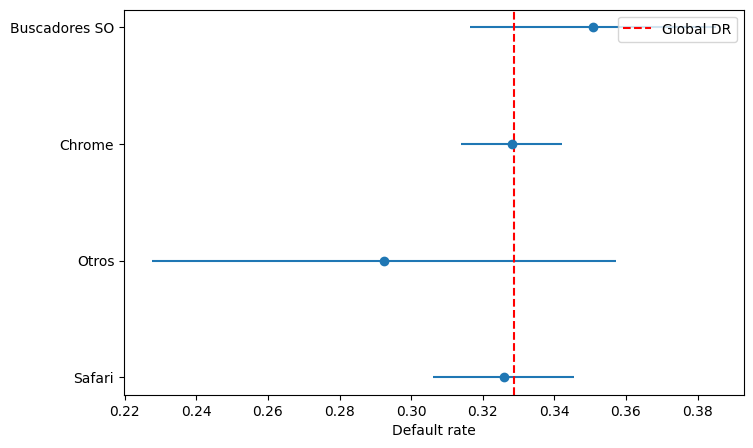

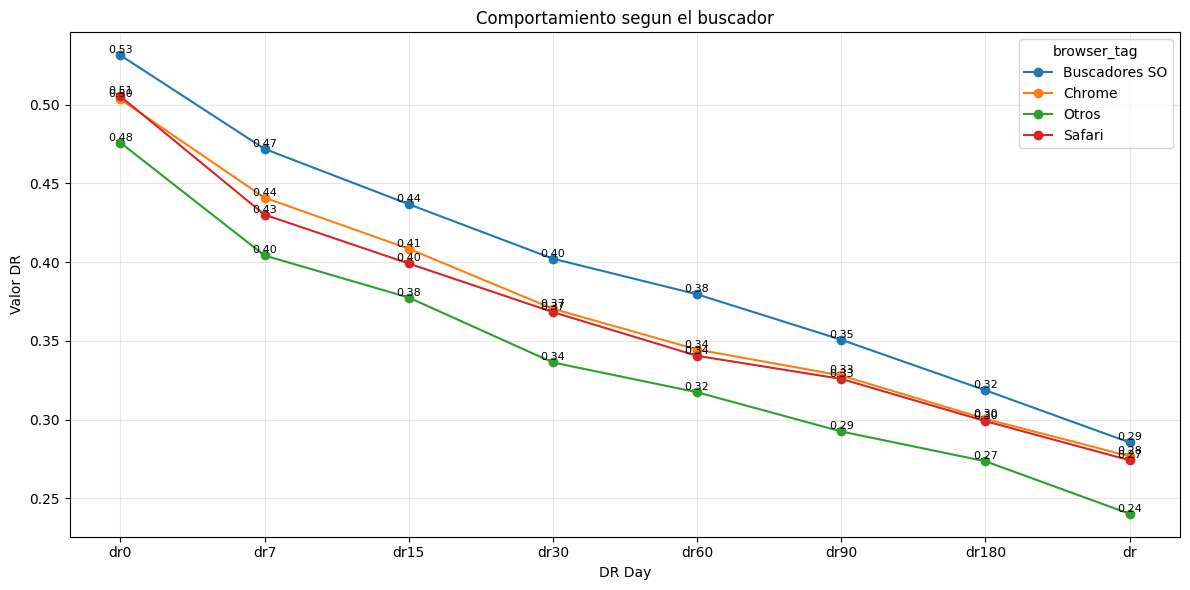

(0.4942071165239315, -0.011585766952136978)


,browser_tag,n_users,dr,lift,se,ci_low,ci_high,ci_width
3,Safari,2169,0.325889,0.991160,0.010064,0.306163,0.345614,acceptable
2,Otros,189,0.292499,0.889608,0.033090,0.227643,0.357355,very_unestable
1,Chrome,4304,0.328066,0.997782,0.007157,0.314039,0.342093,very_stable
0,Buscadores SO,742,0.350767,1.066824,0.017519,0.316430,0.385104,very_unestable


In [ ]:



def browser_tag(browser):
    if 'safari' in browser.lower():
        return 'Safari'

    if 'chrome' in browser.lower():
        return 'Chrome'

    if 'edge' in browser.lower():
        return 'Edge'

    if ('samsung' in browser.lower()) | ('google' in browser.lower())| ('miui' in browser.lower()):
        return 'Buscadores SO'

    return 'Otros' 
    

# Unificaremos los diferentes buscadores para evitar tener tantos tipos diferentes

df_data["browser_tag"] = df_data["browser_family"].apply(lambda x: browser_tag(x))


result = full_analysis_by_var(df_data, 'browser_tag', 'dr90', 'Comportamiento segun el buscador', dr_evolution=False, calculate_gini=False)
print(auc_gini(df_data, "browser_tag", "dr90"))
result["lift_table"]

In [ ]:
df_data["browser_family_flag"].value_counts().reset_index()

,browser_family_flag,count
0,Chrome,4304
1,Safari,2169
2,Buscadores SO,742
3,Edge,95
4,Otros,94


In [ ]:
from datetime import date, datetime
# Obtenemos la fecha actual
today = date.today()
# Fecha de inicio del año actual
start_of_year = datetime(today.year, 1, 1).strftime("%Y-%m-%d")

print(start_of_year)

2026-01-01
